In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Oculta INFO e WARNING, mantém ERROS visíveis

#'0' → Mostra todos os logs
#'1' → Oculta logs INFO
#'2' → Oculta INFO e WARNING (recomendado no seu caso)
#'3' → Oculta todos os logs, mostrando apenas erros críticos

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import random

In [3]:
import os

csv_path = "/notebooks/stage_2_train_labels_800.csv"

# Verificar se o arquivo existe
if os.path.exists(csv_path):
    print("Arquivo encontrado!")
else:
    print("Erro: O arquivo não foi encontrado.")

Arquivo encontrado!


In [4]:
import pandas as pd

# Carregar o CSV
df = pd.read_csv(csv_path)

# Mostrar as primeiras linhas do dataset
print(df.head(10))

                              patientId    x    y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0    0      1       1       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0    0      1       1       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    0    0      1       1       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0    0      1       1       0
4  00436515-870c-4b36-a041-de91049b9ab4  206  119    166     296       1
5  00436515-870c-4b36-a041-de91049b9ab4  439  119    200     354       1
6  00569f44-917d-4c86-a842-81832af98c30    0    0      1       1       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    0    0      1       1       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  252  451    125      81       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  543  449    127     107       1


In [5]:
# Exibir informações gerais do dataset
print("Número total de amostras:", len(df))
print("\nColunas disponíveis:", df.columns.tolist())
print("\nValores ausentes por coluna:\n", df.isnull().sum())
print("\nDistribuição das labels:\n", df['Target'].value_counts())

Número total de amostras: 30227

Colunas disponíveis: ['patientId', 'x', 'y', 'width', 'height', 'Target']

Valores ausentes por coluna:
 patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

Distribuição das labels:
 Target
0    20672
1     9555
Name: count, dtype: int64


In [6]:
# Verificar duplicatas no patientId (podem ser válidas se tiver múltiplas bounding boxes)
duplicated_ids = df["patientId"].duplicated().sum()
print(f"Número de IDs duplicados: {duplicated_ids}")

# Verificar duplicatas exatas em todas as colunas (erro real se existir)
duplicated_rows = df.duplicated().sum()
print(f"Número de linhas completamente duplicadas: {duplicated_rows}")

# Mostrar exemplos de IDs que aparecem mais de uma vez
print("\nExemplos de imagens com múltiplas entradas no CSV:")
print(df[df.duplicated("patientId", keep=False)].head(10))

Número de IDs duplicados: 3543
Número de linhas completamente duplicadas: 0

Exemplos de imagens com múltiplas entradas no CSV:
                               patientId    x    y  width  height  Target
4   00436515-870c-4b36-a041-de91049b9ab4  206  119    166     296       1
5   00436515-870c-4b36-a041-de91049b9ab4  439  119    200     354       1
8   00704310-78a8-4b38-8475-49f4573b2dbb  252  451    125      81       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  543  449    127     107       1
14  00aecb01-a116-45a2-956c-08d2fa55433f  225  252     73     105       1
15  00aecb01-a116-45a2-956c-08d2fa55433f  427  234     93     129       1
16  00c0b293-48e7-4e16-ac76-9269ba535a62  239  425    131     191       1
17  00c0b293-48e7-4e16-ac76-9269ba535a62  508  399    161     222       1
19  00f08de1-517e-4652-a04f-d1dc9ee48593  141  144    161     395       1
20  00f08de1-517e-4652-a04f-d1dc9ee48593  446  215    180     372       1


In [7]:
import os

# Caminho das imagens
image_folder = "/notebooks/RSNA_Resized_800/"

# Criar um conjunto com os nomes das imagens na pasta
image_files = set(os.listdir(image_folder))

# Criar um conjunto com os nomes das imagens do CSV (adicionando ".png" no final)
csv_images = set(df["patientId"] + ".png")

# Verificar quantas imagens estão presentes e quantas faltam
missing_images = csv_images - image_files
print(f"Total de imagens no CSV: {len(csv_images)}")
print(f"Total de imagens encontradas na pasta: {len(csv_images) - len(missing_images)}")
print(f"Total de imagens ausentes: {len(missing_images)}")

# Se houver imagens ausentes, mostrar algumas
if missing_images:
    print("\nExemplos de imagens ausentes:", list(missing_images)[:10])


Total de imagens no CSV: 26684
Total de imagens encontradas na pasta: 26684
Total de imagens ausentes: 0


In [8]:
### Verificar se as bounding boxes estao bem posicionadas

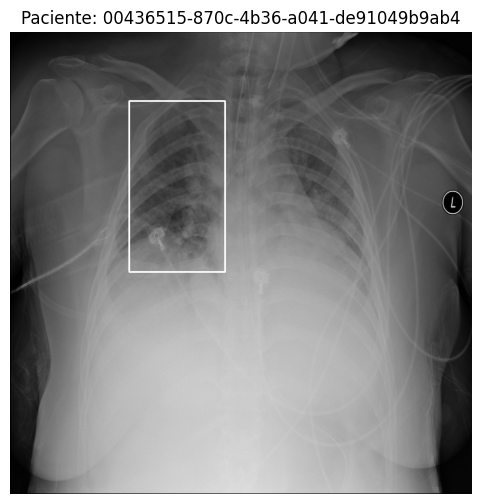

In [9]:
# Verificar uma Imagem com Bounding Box
import matplotlib.pyplot as plt
import cv2
import os

# Caminho do CSV e das imagens
csv_path = "/notebooks/stage_2_train_labels_800.csv"
image_folder = "/notebooks/RSNA_Resized_800/"

# Carregar o CSV
df = pd.read_csv(csv_path)

# Filtrar uma imagem que tenha pneumonia (Target = 1)
df_pneumonia = df[df["Target"] == 1]
sample_patient = df_pneumonia.iloc[0]  # Pegar a primeira imagem com pneumonia

# Carregar a imagem
img_path = os.path.join(image_folder, sample_patient["patientId"] + ".png")
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Verificar se a imagem foi carregada corretamente
if image is None:
    print(f"Erro ao carregar a imagem: {img_path}")
else:
    # Obter bounding box já ajustada
    x, y, w, h = int(sample_patient["x"]), int(sample_patient["y"]), int(sample_patient["width"]), int(sample_patient["height"])

    # Desenhar bounding box
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Exibir a imagem com a bounding box
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap="gray")
    plt.title(f"Paciente: {sample_patient['patientId']}")
    plt.axis("off")
    plt.show()


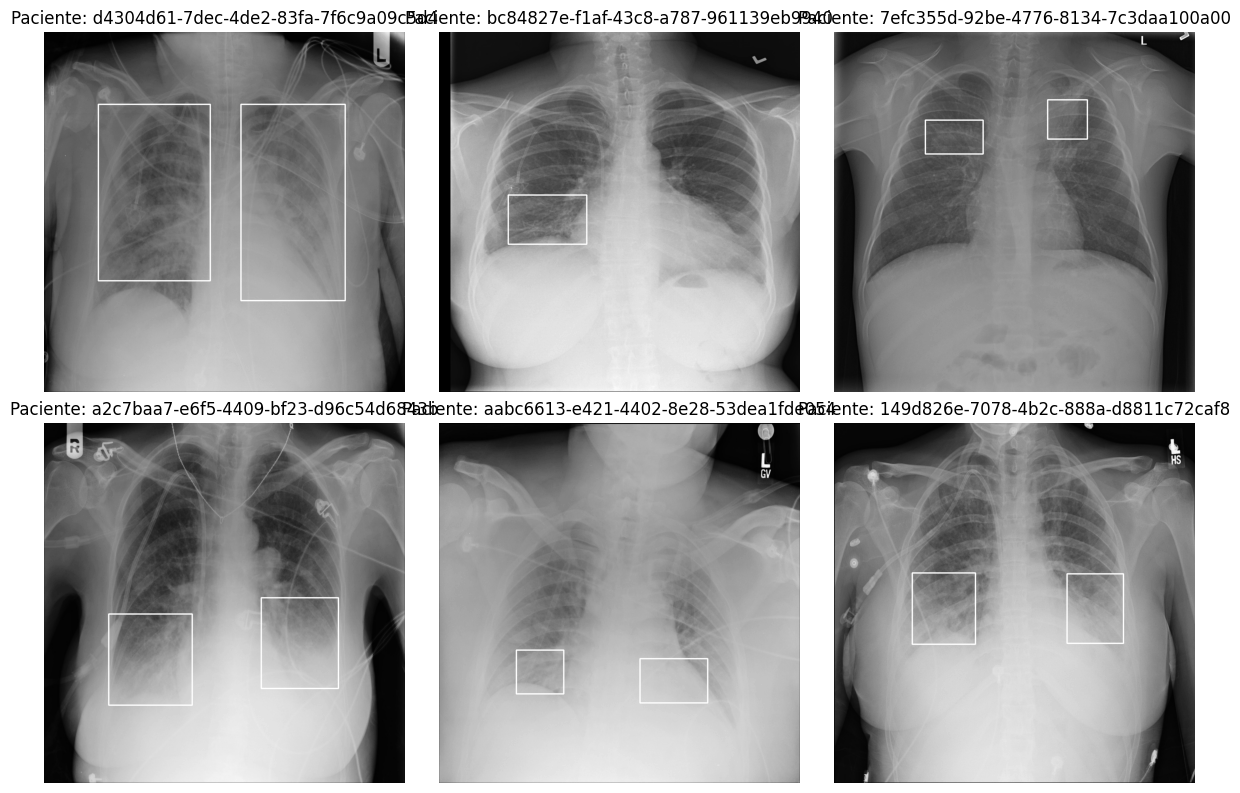

In [10]:
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

# Caminhos do CSV e das imagens
csv_path = "/notebooks/stage_2_train_labels_800.csv"
image_folder = "/notebooks/RSNA_Resized_800/"

# Carregar o CSV
df = pd.read_csv(csv_path)

# Filtrar apenas imagens com pneumonia (Target = 1)
df_pneumonia = df[df["Target"] == 1]

# Selecionar algumas imagens aleatórias para visualização
sample_patients = df_pneumonia["patientId"].sample(6).values

# Criar figura para exibir múltiplas imagens
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, patient_id in enumerate(sample_patients):
    img_path = os.path.join(image_folder, patient_id + ".png")
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Verificar se a imagem foi carregada corretamente
    if image is not None:
        # Pegar todas as bounding boxes associadas a esta imagem (corrigidas)
        boxes = df_pneumonia[df_pneumonia["patientId"] == patient_id][["x", "y", "width", "height"]].values

        # Desenhar as bounding boxes
        for (x, y, w, h) in boxes:
            x, y, w, h = int(x), int(y), int(w), int(h)
            cv2.rectangle(image, (x, y), (x + w, y + h), (255), 2)

        # Mostrar a imagem
        ax = axes[i // 3, i % 3]
        ax.imshow(image, cmap="gray")
        ax.set_title(f"Paciente: {patient_id}")
        ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
#  Verificar o tamanho real das imagens
import os
import cv2
import random

# Caminho das imagens
image_folder = "/notebooks/RSNA_Resized_800/"

# Obter uma lista de algumas imagens aleatórias
sample_images = random.sample(os.listdir(image_folder), 5)

# Verificar tamanho de cada imagem
for img_name in sample_images:
    img_path = os.path.join(image_folder, img_name)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if image is not None:
        print(f"Imagem: {img_name} - Tamanho: {image.shape}")
    else:
        print(f"⚠️ Erro ao carregar: {img_name}")


Imagem: 76c9e6e4-9cb5-4475-89cf-23b20b0be522.png - Tamanho: (800, 800)
Imagem: 91b0043a-35bd-4cf9-b338-1cbc9b05b76d.png - Tamanho: (800, 800)
Imagem: 6f1242ee-a9c8-4931-8787-9060be4bcfdc.png - Tamanho: (800, 800)
Imagem: f144cfd3-a0be-4c5f-aba6-0f211fcaa04a.png - Tamanho: (800, 800)
Imagem: 63efbaf9-13bb-498d-80e1-fed27bb7506e.png - Tamanho: (800, 800)


In [12]:
# Código para verificar se labels e imagens estão alinhados
import pandas as pd
import os

# Caminho dos arquivos
csv_path = "/notebooks/stage_2_train_labels_800.csv"
image_folder = "/notebooks/RSNA_Resized_800/"

# Carregar CSV
df = pd.read_csv(csv_path)

# Definir o tamanho esperado das imagens
IMG_WIDTH = 800  # Novo tamanho correto
IMG_HEIGHT = 800

# Criar listas para verificar problemas
problemas = []

# Verificar cada bounding box
for _, row in df.iterrows():
    patient_id = row["patientId"]
    img_path = os.path.join(image_folder, patient_id + ".png")

    # Verificar se a imagem existe
    if not os.path.exists(img_path):
        problemas.append(f"Imagem ausente: {patient_id}")

    # Se a imagem tem pneumonia (Target=1), verificar bounding box
    if row["Target"] == 1:
        x, y, w, h = row["x"], row["y"], row["width"], row["height"]

        # Verificar valores negativos ou bounding boxes que saem dos limites
        if x < 0 or y < 0 or w <= 0 or h <= 0:
            problemas.append(f"Bounding Box inválida para {patient_id}: x={x}, y={y}, w={w}, h={h}")
        if x + w > IMG_WIDTH or y + h > IMG_HEIGHT:
            problemas.append(f"Bounding Box fora dos limites para {patient_id}: x={x}, y={y}, w={w}, h={h}")

# Exibir problemas encontrados
if problemas:
    print(f"⚠️ Foram encontrados {len(problemas)} problemas:")
    for p in problemas[:10]:  # Mostrar apenas os primeiros 10 problemas
        print(p)
else:
    print("✅ Tudo certo! Todas as imagens e labels estão alinhadas corretamente.")


✅ Tudo certo! Todas as imagens e labels estão alinhadas corretamente.


In [13]:
print(df.isna().sum())  
# Confirma se todas as colunas estão sem valores NaN e que os dados estão prontos para a divisão de treino e validação.
# Se houver NaN, pode ser necessário corrigir antes de prosseguir.

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64


In [14]:
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd

# Carregar CSV com bounding boxes e classes
labels_path = "/notebooks/stage_2_train_labels_800.csv"
df = pd.read_csv(labels_path)

# Selecionar as colunas necessárias
df = df[['patientId', 'Target', 'x', 'y', 'width', 'height']]

# Configurar GroupShuffleSplit para dividir 80% treino e 20% validação
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Criar índices para treino e validação
train_idx, val_idx = next(gss.split(df, groups=df['patientId']))

# Criar DataFrames separados
train_data = df.iloc[train_idx].reset_index(drop=True)
val_data = df.iloc[val_idx].reset_index(drop=True)

# 📌 Verificar distribuição das classes
print("\nDistribuição no conjunto de treino:")
print(train_data["Target"].value_counts(normalize=True))

print("\nDistribuição no conjunto de validação:")
print(val_data["Target"].value_counts(normalize=True))

# 📌 Verificar os tamanhos dos conjuntos
print(f"\nTamanho do conjunto de treino: {len(train_data)}")
print(f"Tamanho do conjunto de validação: {len(val_data)}")


Distribuição no conjunto de treino:
Target
0    0.685914
1    0.314086
Name: proportion, dtype: float64

Distribuição no conjunto de validação:
Target
0    0.67584
1    0.32416
Name: proportion, dtype: float64

Tamanho do conjunto de treino: 24159
Tamanho do conjunto de validação: 6068


In [15]:
# Criar bounding boxes e labels corretamente

import tensorflow as tf

# Criar dicionários onde cada imagem tem todas as bounding boxes associadas
train_boxes = {}
val_boxes = {}

for _, row in train_data.iterrows():
    pid = row["patientId"]
    bbox = [row["x"], row["y"], row["width"], row["height"]]
    
    if pid in train_boxes:
        train_boxes[pid].append(bbox)
    else:
        train_boxes[pid] = [bbox]

for _, row in val_data.iterrows():
    pid = row["patientId"]
    bbox = [row["x"], row["y"], row["width"], row["height"]]
    
    if pid in val_boxes:
        val_boxes[pid].append(bbox)
    else:
        val_boxes[pid] = [bbox]

# 📌 Criar listas de caminhos das imagens 
image_folder = "/notebooks/RSNA_Resized_800/"

# 🔹 Criar listas corretas de imagens SEM ERRO de KeyError
train_image_paths = list(train_boxes.keys())  # Apenas os patientIds
val_image_paths = list(val_boxes.keys())

# Criar listas de bounding boxes e labels 
train_boxes_list = [train_boxes[pid] for pid in train_image_paths]
train_labels = [tf.ones((len(boxes),), dtype=tf.int32) for boxes in train_boxes_list]

val_boxes_list = [val_boxes[pid] for pid in val_image_paths]
val_labels = [tf.ones((len(boxes),), dtype=tf.int32) for boxes in val_boxes_list]

# 📌 Converter para tf.RaggedTensor (permite diferentes quantidades de bounding boxes)
#train_boxes_list = tf.ragged.constant(train_boxes_list, dtype=tf.float32)
#val_boxes_list = tf.ragged.constant(val_boxes_list, dtype=tf.float32)

# 📌 Agora ajustar os caminhos das imagens para incluir a pasta correta
train_image_paths = [image_folder + pid + ".png" for pid in train_image_paths]
val_image_paths = [image_folder + pid + ".png" for pid in val_image_paths]

# 📌 Verificar tamanhos para evitar erros no pipeline
print(f"Tamanho de train_image_paths: {len(train_image_paths)}")
print(f"Tamanho de train_boxes_list: {len(train_boxes_list)}")  # 🔹 Corrigido
print(f"Tamanho de train_labels: {len(train_labels)}")

print(f"\nTamanho de val_image_paths: {len(val_image_paths)}")
print(f"Tamanho de val_boxes_list: {len(val_boxes_list)}")  # 🔹 Corrigido
print(f"Tamanho de val_labels: {len(val_labels)}")

Tamanho de train_image_paths: 21347
Tamanho de train_boxes_list: 21347
Tamanho de train_labels: 21347

Tamanho de val_image_paths: 5337
Tamanho de val_boxes_list: 5337
Tamanho de val_labels: 5337


📊 **Distribuição das classes no treino:**
Target
0    16571
1     7588
Name: count, dtype: int64

🔢 **Proporção das classes no treino:**
Target
0    0.685914
1    0.314086
Name: count, dtype: float64

📊 **Distribuição das classes na validação:**
Target
0    4101
1    1967
Name: count, dtype: int64

🔢 **Proporção das classes na validação:**
Target
0    0.67584
1    0.32416
Name: count, dtype: float64


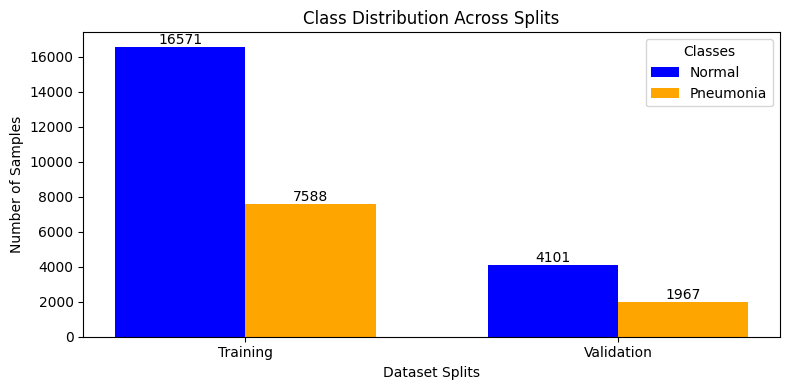

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Definir os conjuntos
splits = ['Training', 'Validation']

# Contar as amostras de cada classe em treino e validação (evita erro se faltar uma classe)
train_counts = train_data["Target"].value_counts().reindex([0, 1], fill_value=0)
val_counts = val_data["Target"].value_counts().reindex([0, 1], fill_value=0)

# Calcular as proporções
train_proportions = train_counts / train_counts.sum()
val_proportions = val_counts / val_counts.sum()

# Exibir os valores absolutos e proporcionais
print("📊 **Distribuição das classes no treino:**")
print(train_counts)
print("\n🔢 **Proporção das classes no treino:**")
print(train_proportions)

print("\n📊 **Distribuição das classes na validação:**")
print(val_counts)
print("\n🔢 **Proporção das classes na validação:**")
print(val_proportions)

# Configurar posições no eixo X
x = np.arange(len(splits))  # Posições para Training e Validation
bar_width = 0.35  # Largura das barras

# Criar gráfico de barras lado a lado
fig, ax = plt.subplots(figsize=(8, 4))
normal_bars = ax.bar(x - bar_width/2, [train_counts[0], val_counts[0]], bar_width, label='Normal', color='blue')
pneumonia_bars = ax.bar(x + bar_width/2, [train_counts[1], val_counts[1]], bar_width, label='Pneumonia', color='orange')

# Adicionar rótulos numéricos nas barras (valores absolutos)
for bars in [normal_bars, pneumonia_bars]:
    for bar in bars:
        ax.annotate(f"{bar.get_height():.0f}",
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    ha='center', va='bottom', fontsize=10)

# Personalizar os eixos
ax.set_xlabel('Dataset Splits')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution Across Splits')
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.legend(title='Classes')

# Melhorar layout
plt.tight_layout()
plt.show()


In [17]:
# Obter os conjuntos de pacientes em treino e validação
train_patients = set(train_data["patientId"])
val_patients = set(val_data["patientId"])

# Encontrar interseção entre os conjuntos
leakage_patients = train_patients.intersection(val_patients)

if len(leakage_patients) > 0:
    print(f"⚠️ Data leakage detectado! {len(leakage_patients)} pacientes estão em ambos os conjuntos.")
    print("Exemplos de IDs com data leakage:", list(leakage_patients)[:10])
else:
    print("✅ Nenhum data leakage encontrado. Conjuntos separados corretamente.")


✅ Nenhum data leakage encontrado. Conjuntos separados corretamente.


📊 **Distribuição do número de bounding boxes por paciente no dataset original (Pneumonia)**:
count    4776.000000
mean        1.588777
std         0.540769
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: count, dtype: float64

📊 **Frequência de pacientes por número de bounding boxes:**
count
1    2075
2    2599
3      93
4       9
Name: count, dtype: int64


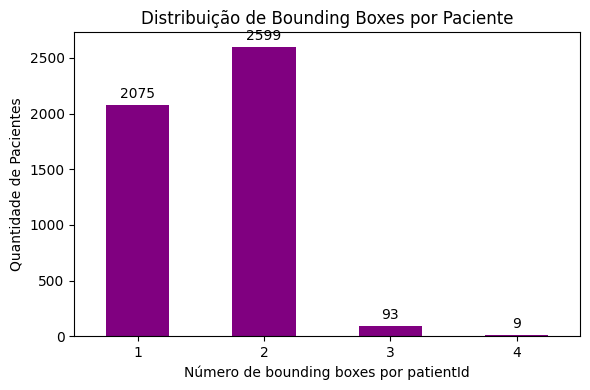

In [18]:
# Verificar de quantas bounding boxes cada paciente tem para ajustar oversample
import pandas as pd

# Contar quantas linhas cada paciente tem no dataset original (antes do oversampling)
bb_counts = train_data[train_data["Target"] == 1]["patientId"].value_counts()

# Exibir estatísticas
print("📊 **Distribuição do número de bounding boxes por paciente no dataset original (Pneumonia)**:")
print(bb_counts.describe())  # Estatísticas gerais

# Contagem de quantos pacientes têm 1, 2, 3, etc. BBs
bb_freq = bb_counts.value_counts().sort_index()

# Exibir distribuição detalhada
print("\n📊 **Frequência de pacientes por número de bounding boxes:**")
print(bb_freq)

# Visualizar a distribuição em gráfico de barras
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
bars = bb_freq.plot(kind='bar', ax=ax, color='purple')

# Personalizar gráfico
ax.set_xlabel("Número de bounding boxes por patientId")
ax.set_ylabel("Quantidade de Pacientes")
ax.set_title("Distribuição de Bounding Boxes por Paciente")

# Adicionar valores numéricos nas barras
ax.bar_label(bars.containers[0], fmt='%d', label_type='edge', fontsize=10, padding=3)

# Ajustar layout
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [19]:
# 📌 Carregar e processar o dataset de bounding boxes
import pandas as pd
import numpy as np

# Carregar o CSV com as bounding boxes ajustadas
csv_path = "/notebooks/stage_2_train_labels_800.csv"
df = pd.read_csv(csv_path)

# 📌 1️⃣ Consolidar múltiplas bounding boxes por paciente
# Para pacientes com pneumonia (Target=1), agrupar todas as BBs
grouped = df[df["Target"] == 1].groupby("patientId")[["x", "y", "width", "height"]].agg(list).reset_index()

# 📌 2️⃣ Criar estrutura final do dataset
# Adicionar coluna Target = 1 para pacientes com pneumonia
grouped["Target"] = 1

# 📌 3️⃣ Criar dataset para imagens normais (sem pneumonia)
# Filtrar apenas pacientes sem pneumonia (Target=0)
df_normal = df[df["Target"] == 0][["patientId"]].drop_duplicates()

# Adicionar colunas de bounding boxes vazias (listas vazias)
df_normal["x"] = df_normal["y"] = df_normal["width"] = df_normal["height"] = [[]] * len(df_normal)  
df_normal["Target"] = 0

# 📌 4️⃣ Combinar os dois datasets
final_df = pd.concat([grouped, df_normal], ignore_index=True)

# 📌 5️⃣ Verificar a estrutura final
print("✅ Dataset final estruturado para treino:")
print(final_df.head())

# 📌 6️⃣ Garantir que os dados estão no formato correto
print("\n📊 Distribuição final das classes:")
class_counts = final_df["Target"].value_counts()
print(class_counts)

# 📌 7️⃣ Exibir o total de amostras no dataset final
total_samples = len(final_df)
print(f"\n🔢 Total de amostras no dataset final: {total_samples}")

# 📌 8️⃣ Exemplo de dados estruturados
print("\n🔍 Exemplo de dados estruturados:")
print(final_df.sample(5))

✅ Dataset final estruturado para treino:
                              patientId           x           y       width  \
0  000db696-cf54-4385-b10b-6b16fbb3f985  [247, 516]  [248, 293]  [133, 114]   
1  000fe35a-2649-43d4-b027-e67796d412e0   [445, 65]  [220, 177]  [210, 231]   
2  001031d9-f904-4a23-b3e5-2c088acd19c6   [52, 431]  [125, 128]  [291, 294]   
3  001916b8-3d30-4935-a5d1-8eaddb1646cd       [155]       [293]        [89]   
4  0022073f-cec8-42ec-ab5f-bc2314649235  [449, 126]  [181, 180]  [192, 174]   

       height  Target  
0  [373, 314]       1  
1  [320, 342]       1  
2  [475, 528]       1  
3       [161]       1  
4  [412, 380]       1  

📊 Distribuição final das classes:
Target
0    20672
1     6012
Name: count, dtype: int64

🔢 Total de amostras no dataset final: 26684

🔍 Exemplo de dados estruturados:
                                  patientId      x      y  width height  \
5280   d4b3478b-d430-4c89-95b5-1c1c27c8eb71  [233]  [297]  [133]  [120]   
7155   2131a5d5-d3ca-

In [20]:
import numpy as np
import pandas as pd

# Definir o tamanho alvo para a classe Pneumonia
target_size_minority = 14000  # Exatamente 14000 amostras

# Separar as duas classes
train_class_0 = train_data[train_data['Target'] == 0]  # Classe Normal
train_class_1 = train_data[train_data['Target'] == 1]  # Classe Pneumonia

# Contar quantas vezes cada paciente aparece
bb_counts = train_class_1["patientId"].value_counts()

# Criar um dicionário que controla quantas cópias extras cada paciente pode ter
patient_to_extra = {}

# Aplicar regras de oversampling
for patient, count in bb_counts.items():
    if count == 1:
        patient_to_extra[patient] = 2  # Paciente com 1 imagem → +2 (total 3)
    elif count == 2:
        patient_to_extra[patient] = 1  # Paciente com 2 imagens → +1 (total 3)
    else:
        patient_to_extra[patient] = 0  # Paciente com 3 ou mais → não recebe extra

# Criar dataset balanceado
oversampled_class_1 = train_class_1.copy()

# Adicionar cópias conforme a regra
for patient_id, n_extra in patient_to_extra.items():
    if n_extra > 0:
        original_rows = train_class_1[train_class_1['patientId'] == patient_id]
        extra_rows = original_rows.sample(n=n_extra, replace=True, random_state=42)
        oversampled_class_1 = pd.concat([oversampled_class_1, extra_rows], ignore_index=True)

# Garantir que ninguém tenha mais de 3 ocorrências (Correção Final)
final_counts = oversampled_class_1['patientId'].value_counts()
excess_patients = final_counts[final_counts > 3].index  # Quem passou de 3 ocorrências

if len(excess_patients) > 0:
    oversampled_class_1 = oversampled_class_1[
        ~((oversampled_class_1['patientId'].isin(excess_patients)) &
          (oversampled_class_1.duplicated(subset=['patientId'], keep='first')))
    ]

# Ajustar para garantir exatamente 11720 amostras
current_size = len(oversampled_class_1)

if current_size > target_size_minority:
    oversampled_class_1 = oversampled_class_1.sample(n=target_size_minority, random_state=42)
elif current_size < target_size_minority:
    deficit = target_size_minority - current_size
    # Agora, garantimos que pegamos apenas IDs que ainda estão abaixo de 3 ocorrências
    current_counts = oversampled_class_1['patientId'].value_counts()
    eligible_ids = current_counts[current_counts < 3].index
    eligible_df = oversampled_class_1[oversampled_class_1['patientId'].isin(eligible_ids)]

    if len(eligible_df) > 0:
        extra_rows = eligible_df.sample(n=deficit, replace=True, random_state=42)
        oversampled_class_1 = pd.concat([oversampled_class_1, extra_rows], ignore_index=True)

# Unir a classe 0 e a classe 1 balanceada
balanced_train_data = pd.concat([train_class_0, oversampled_class_1], ignore_index=True)
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# 📊 Estatísticas finais
print("\n📊 **Distribuição final das classes no conjunto de treino:**")
print(balanced_train_data['Target'].value_counts())

# 📊 Verificar duplicatas na classe Pneumonia
minority_data = balanced_train_data[balanced_train_data['Target'] == 1]
patient_id_counts = minority_data['patientId'].value_counts()

print("\n📊 **Estatísticas das duplicatas na classe Pneumonia:**")
print(f"🔹 Máximo de duplicatas por patientId: {patient_id_counts.max()}  (Deve ser no máximo 3)")
print(f"🔹 Mínimo de duplicatas por patientId: {patient_id_counts.min()}")  
print(f"🔹 Total de IDs duplicados (quem aparece mais de 1x): {sum(patient_id_counts > 1)}")  
print(f"🔹 Total de amostras na classe Pneumonia: {len(minority_data)}")  
print(f"🔹 Número único de patientIds na Pneumonia: {len(patient_id_counts)}")  



📊 **Distribuição final das classes no conjunto de treino:**
Target
0    16571
1    14000
Name: count, dtype: int64

📊 **Estatísticas das duplicatas na classe Pneumonia:**
🔹 Máximo de duplicatas por patientId: 3  (Deve ser no máximo 3)
🔹 Mínimo de duplicatas por patientId: 1
🔹 Total de IDs duplicados (quem aparece mais de 1x): 4761
🔹 Total de amostras na classe Pneumonia: 14000
🔹 Número único de patientIds na Pneumonia: 4776



📊 **Distribuição do conjunto de treino após oversampling:**
Target
0    16571
1    14000
Name: count, dtype: int64

🔢 **Total de amostras no conjunto de treino balanceado:** 30571

🔍 **Ocorrências por patientId na classe Pneumonia (exemplo):**
patientId
b829458e-0a00-4d7f-9b19-0efd59f2cd7a    3
15d3c938-6ccd-4abe-a49d-5fb469a1ea14    3
7b3e4cf6-f37e-4e95-a6c8-3901352dbd15    3
100fb3d8-99c5-4723-9385-11b236f9aae4    3
a3729a13-c791-4f7b-bd48-fbaf4f7fc0e4    3
Name: count, dtype: int64

📊 **Estatísticas das duplicatas na classe Pneumonia:**
🔹 Máximo de duplicatas por patientId: 3
🔹 Mínimo de duplicatas por patientId: 1
🔹 Total de IDs duplicados: 4761
🔹 Total de amostras na classe Pneumonia: 14000
🔹 Número único de patientIds na Pneumonia: 4776

🔍 Número de duplicatas no dataset balanceado (considerando bounding boxes): 6507


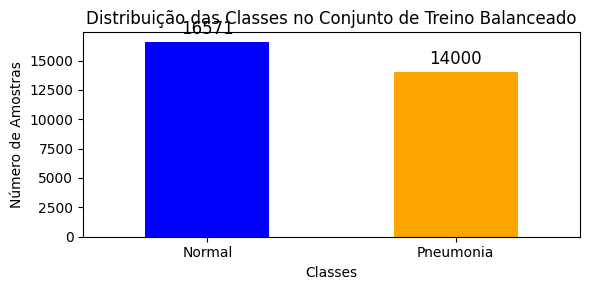

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# 📌 1️⃣ Verificar distribuição final das classes
print("\n📊 **Distribuição do conjunto de treino após oversampling:**")
class_counts = balanced_train_data['Target'].value_counts()
print(class_counts)

# 📌 2️⃣ Exibir total de amostras
total_samples = len(balanced_train_data)
print(f"\n🔢 **Total de amostras no conjunto de treino balanceado:** {total_samples}")

# 📌 3️⃣ Verificar duplicatas na classe minoritária (Pneumonia)
minority_data = balanced_train_data[balanced_train_data['Target'] == 1]

# Contar quantas vezes cada 'patientId' aparece
patient_id_counts = minority_data['patientId'].value_counts()

# Mostrar alguns exemplos
print("\n🔍 **Ocorrências por patientId na classe Pneumonia (exemplo):**")
print(patient_id_counts.head())

# 📌 4️⃣ Estatísticas das duplicatas
print("\n📊 **Estatísticas das duplicatas na classe Pneumonia:**")
print(f"🔹 Máximo de duplicatas por patientId: {patient_id_counts.max()}")
print(f"🔹 Mínimo de duplicatas por patientId: {patient_id_counts.min()}")
print(f"🔹 Total de IDs duplicados: {sum(patient_id_counts > 1)}")
print(f"🔹 Total de amostras na classe Pneumonia: {len(minority_data)}")
print(f"🔹 Número único de patientIds na Pneumonia: {len(patient_id_counts)}")

# 📌 5️⃣ Verificar duplicatas no dataset balanceado
# Considera todas as colunas relevantes para evitar falsa contagem de múltiplas bounding boxes no mesmo paciente
num_duplicates = balanced_train_data.duplicated(subset=['patientId', 'x', 'y', 'width', 'height']).sum()
print(f"\n🔍 Número de duplicatas no dataset balanceado (considerando bounding boxes): {num_duplicates}")

# 📌 6️⃣ Criar gráfico de barras para mostrar a distribuição das classes
fig, ax = plt.subplots(figsize=(6, 3))

# Criar gráfico
bars = balanced_train_data['Target'].value_counts().plot(kind='bar', ax=ax, color=['blue', 'orange'])

# Adicionar rótulos aos eixos
ax.set_xlabel('Classes')
ax.set_ylabel('Número de Amostras')
ax.set_xticklabels(['Normal', 'Pneumonia'], rotation=0)
ax.set_title('Distribuição das Classes no Conjunto de Treino Balanceado')

# Adicionar valores numéricos acima das barras
ax.bar_label(bars.containers[0], fmt='%d', label_type='edge', fontsize=12, padding=3)

# Ajustar layout
plt.tight_layout()
plt.show()


In [22]:
# 📌 Verificar duplicatas no dataset balanceado
import pandas as pd

# Filtrar apenas amostras de pneumonia
pneumonia_samples = balanced_train_data[balanced_train_data["Target"] == 1]

# Contar quantas vezes cada patientId aparece
patient_dup_counts = pneumonia_samples["patientId"].value_counts()

# Exibir alguns exemplos de pacientes que foram duplicados
print("🔍 Exemplo de pacientes duplicados:")
duplicated_patients = patient_dup_counts[patient_dup_counts > 1].index[:5]  # Pegar 5 exemplos

for patient in duplicated_patients:
    print(f"\nPaciente: {patient}")
    print(pneumonia_samples[pneumonia_samples["patientId"] == patient][["x", "y", "width", "height"]])

🔍 Exemplo de pacientes duplicados:

Paciente: b829458e-0a00-4d7f-9b19-0efd59f2cd7a
        x    y  width  height
2      48  280    212     277
4764   48  280    212     277
16814  48  280    212     277

Paciente: 15d3c938-6ccd-4abe-a49d-5fb469a1ea14
         x    y  width  height
9271   530  330    177     216
19130  177  376    197     162
27489  177  376    197     162

Paciente: 7b3e4cf6-f37e-4e95-a6c8-3901352dbd15
         x    y  width  height
9295   537  477    148     129
21966  218  438    129     127
25873  218  438    129     127

Paciente: 100fb3d8-99c5-4723-9385-11b236f9aae4
         x    y  width  height
9292   554  292    154     312
12927  188  327    168     300
24036  188  327    168     300

Paciente: a3729a13-c791-4f7b-bd48-fbaf4f7fc0e4
         x    y  width  height
9290   524  215    145     320
26145  524  215    145     320
30402  206   94    165     418



📊 **Frequência de duplicatas na classe Pneumonia:**
count
1      15
2     298
3    4463
Name: count, dtype: int64


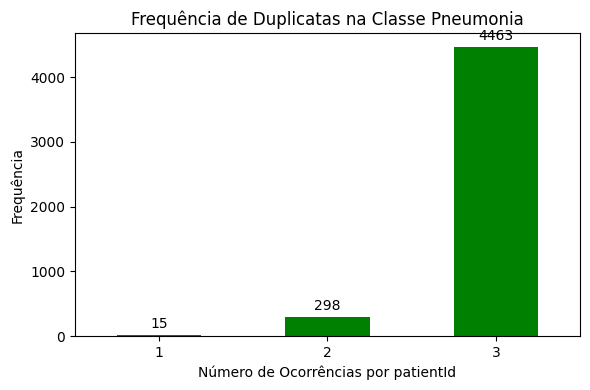

In [23]:
import matplotlib.pyplot as plt

# 📌 1️⃣ Contar a frequência de duplicatas na classe minoritária (Pneumonia)
dup_counts = patient_id_counts.value_counts().sort_index()  # Ordena para gráfico correto

# 📌 2️⃣ Exibir contagem das duplicatas
print("\n📊 **Frequência de duplicatas na classe Pneumonia:**")
print(dup_counts)

# 📌 3️⃣ Criar gráfico de barras para visualizar a distribuição das duplicatas
fig, ax = plt.subplots(figsize=(6, 4))

# Criar gráfico
bars = dup_counts.plot(kind='bar', ax=ax, color='green')

# Adicionar rótulos aos eixos
ax.set_xlabel('Número de Ocorrências por patientId')
ax.set_ylabel('Frequência')
ax.set_title('Frequência de Duplicatas na Classe Pneumonia')
ax.set_xticklabels(dup_counts.index, rotation=0)  # Ajusta rótulos do eixo X corretamente

# Adicionar valores numéricos nas barras
ax.bar_label(bars.containers[0], fmt='%d', label_type='edge', fontsize=10, padding=3)

# Ajustar layout
plt.tight_layout()
plt.show()


In [24]:
import os

# Caminho da pasta única onde todas as imagens estão armazenadas
image_folder = "/notebooks/RSNA_Resized_800/"

# Função para verificar se todas as imagens listadas no CSV estão na pasta correta
def check_images_existence(data, set_name):
    """
    Verifica se todas as imagens referenciadas no dataset estão presentes na pasta única.

    Parameters:
        data (DataFrame): DataFrame contendo a coluna 'patientId'.
        set_name (str): Nome do conjunto ('Treino' ou 'Validação').
    """
    missing_files = []  # Lista para armazenar arquivos ausentes

    # Criar lista de nomes de arquivos esperados no diretório
    expected_files = set(data["patientId"] + ".png")

    # Criar conjunto dos arquivos que realmente estão na pasta
    available_files = set(os.listdir(image_folder))

    # Verificar quais imagens estão faltando
    missing_files = expected_files - available_files

    # Exibir resultados
    if missing_files:
        print(f"⚠️ {len(missing_files)} arquivos ausentes no conjunto {set_name}.")
        print(f"Exemplos de arquivos ausentes: {list(missing_files)[:5]}")
    else:
        print(f"✅ Todas as imagens do conjunto {set_name} estão presentes.")

# Verificar as imagens para o conjunto de treino e validação
print("🔍 **Verificando a existência de imagens:**")
check_images_existence(balanced_train_data, 'Treino')
check_images_existence(val_data, 'Validação')

🔍 **Verificando a existência de imagens:**
✅ Todas as imagens do conjunto Treino estão presentes.
✅ Todas as imagens do conjunto Validação estão presentes.


In [25]:
# 📌 1️⃣ Verificar distribuição final das classes
print("\n📊 **Distribuição do conjunto de treino após oversampling:**")
print(balanced_train_data['Target'].value_counts())

# 📌 2️⃣ Exibir total de amostras
print(f"\n🔢 **Total de amostras no conjunto de treino balanceado:** {len(balanced_train_data)}")

# 📌 3️⃣ Contar duplicatas na classe Pneumonia
minority_data = balanced_train_data[balanced_train_data['Target'] == 1]
patient_id_counts = minority_data['patientId'].value_counts()
num_duplicated_ids = sum(patient_id_counts > 1)

print("\n📊 **Estatísticas das duplicatas na classe Pneumonia:**")
print(f"🔹 Total de IDs duplicados: {num_duplicated_ids}")

# 📌 4️⃣ Verificar duplicatas considerando bounding boxes
num_duplicates = balanced_train_data.duplicated(subset=['patientId', 'x', 'y', 'width', 'height']).sum()
print(f"\n🔍 Número de duplicatas no dataset balanceado (considerando bounding boxes): {num_duplicates}")

# 📌 5️⃣ Verificar se todas as imagens existem
print("\n🔍 **Verificando a existência de imagens:**")
check_images_existence(balanced_train_data, 'Treino')
check_images_existence(val_data, 'Validação')



📊 **Distribuição do conjunto de treino após oversampling:**
Target
0    16571
1    14000
Name: count, dtype: int64

🔢 **Total de amostras no conjunto de treino balanceado:** 30571

📊 **Estatísticas das duplicatas na classe Pneumonia:**
🔹 Total de IDs duplicados: 4761

🔍 Número de duplicatas no dataset balanceado (considerando bounding boxes): 6507

🔍 **Verificando a existência de imagens:**
✅ Todas as imagens do conjunto Treino estão presentes.
✅ Todas as imagens do conjunto Validação estão presentes.


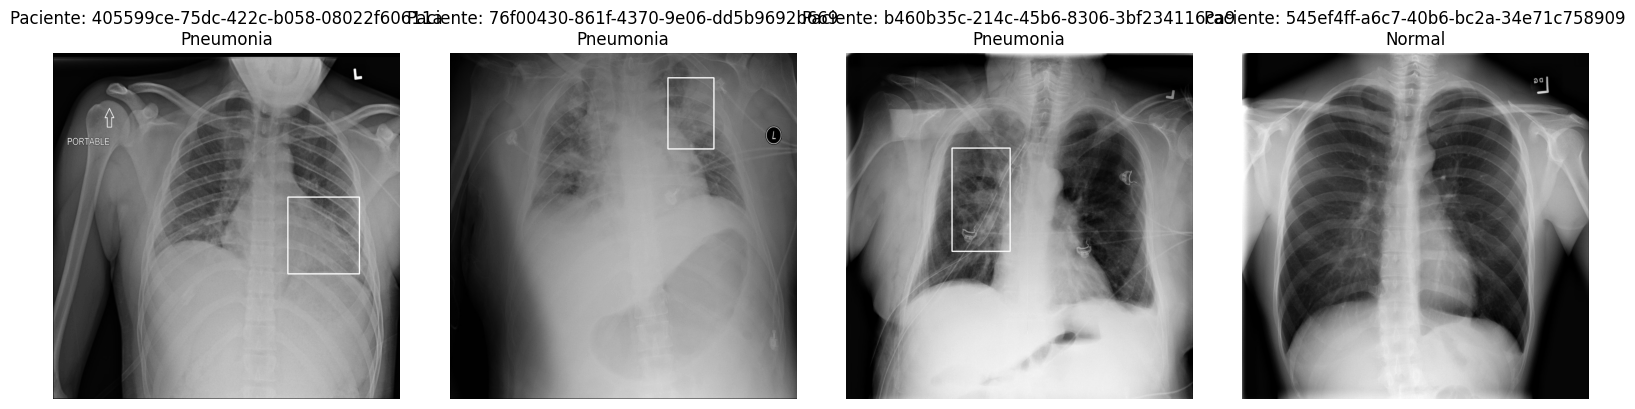

In [26]:
import random
import matplotlib.pyplot as plt
import cv2
import os

# Caminho das imagens
image_folder = "/notebooks/RSNA_Resized_800/"  # Diretório das imagens

# Selecionar amostras aleatórias
num_samples = 4  # Número de imagens para exibir
sample_patients = random.sample(balanced_train_data['patientId'].unique().tolist(), num_samples)

# Criar figura para exibição
fig, axes = plt.subplots(1, num_samples, figsize=(16, 4))

for i, patient_id in enumerate(sample_patients):
    img_path = os.path.join(image_folder, patient_id + ".png")
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Verificar se a imagem foi carregada corretamente
    if image is not None:
        # Obter bounding boxes associadas ao paciente
        patient_data = balanced_train_data[balanced_train_data["patientId"] == patient_id]

        if patient_data["Target"].values[0] == 1:  # Apenas se for Pneumonia
            x_coords = patient_data["x"].values[0]
            y_coords = patient_data["y"].values[0]
            widths = patient_data["width"].values[0]
            heights = patient_data["height"].values[0]

            # Converter para listas se forem valores únicos
            x_coords = x_coords if isinstance(x_coords, list) else [x_coords]
            y_coords = y_coords if isinstance(y_coords, list) else [y_coords]
            widths = widths if isinstance(widths, list) else [widths]
            heights = heights if isinstance(heights, list) else [heights]

            # Desenhar bounding boxes na imagem
            for x, y, w, h in zip(x_coords, y_coords, widths, heights):
                x, y, w, h = int(x), int(y), int(w), int(h)
                cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Azul

        # Exibir imagem com bounding boxes (se houver)
        ax = axes[i]
        ax.imshow(image, cmap="gray")
        ax.set_title(f"Paciente: {patient_id}\n{'Pneumonia' if patient_data['Target'].values[0] == 1 else 'Normal'}")
        ax.axis("off")
    else:
        print(f"⚠️ Erro ao carregar a imagem: {img_path}")

# Ajustar layout
plt.tight_layout()
plt.show()


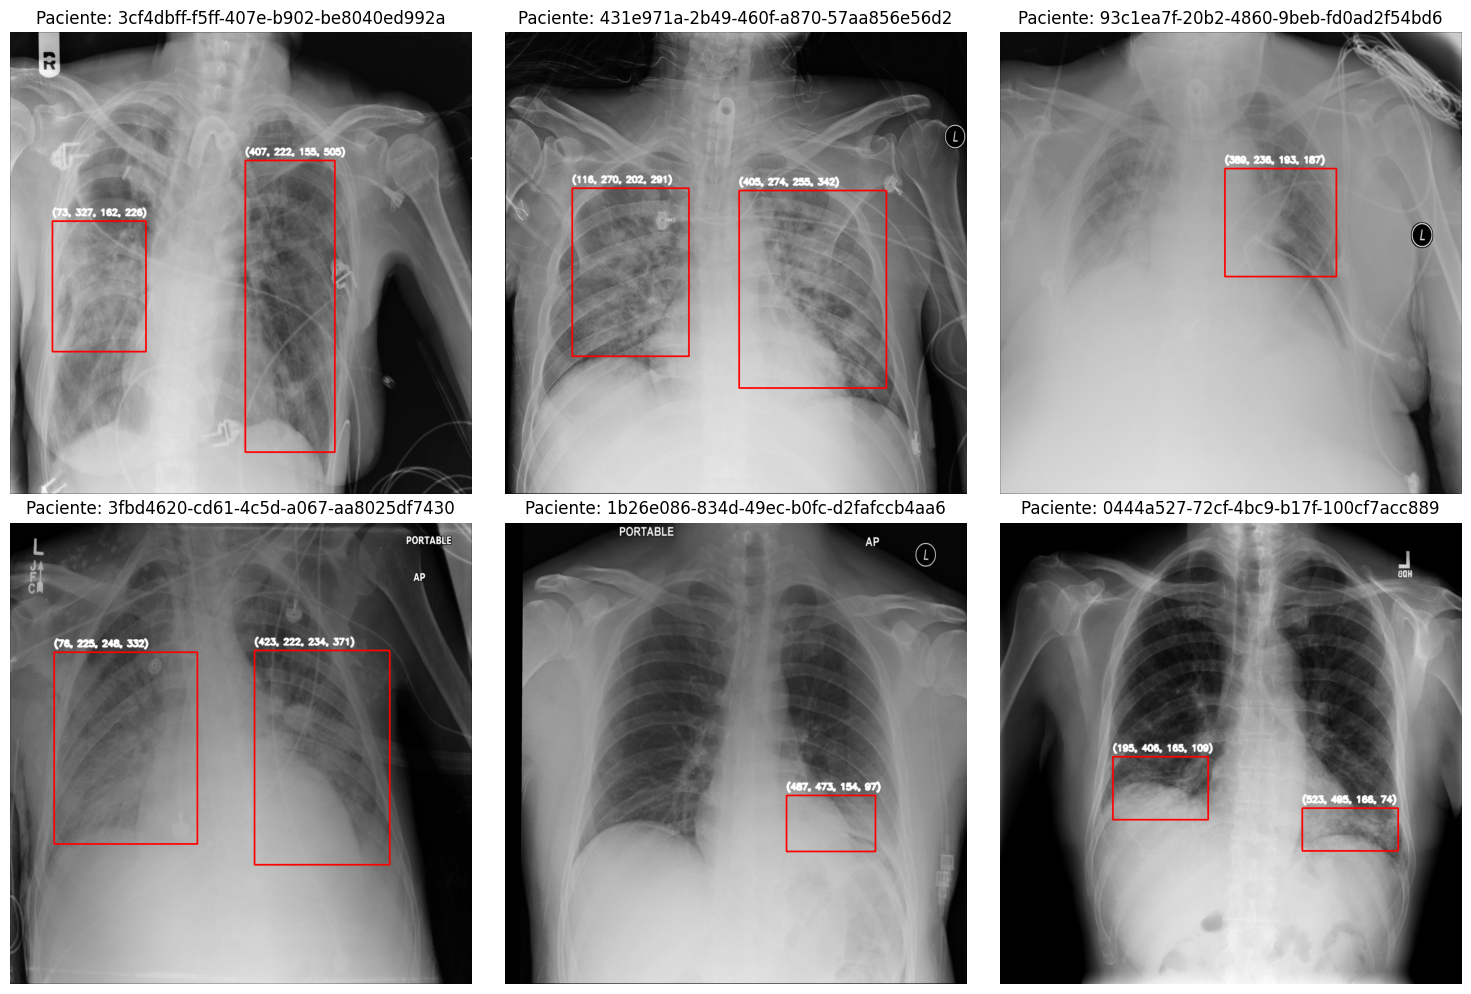

In [27]:
import cv2
import matplotlib.pyplot as plt
import os
import random

# Diretório das imagens
image_dir = "/notebooks/RSNA_Resized_800/"

# Número de imagens a exibir
num_samples = 6  

# Selecionar N pacientes aleatórios com pneumonia
sample_patients = balanced_train_data[balanced_train_data["Target"] == 1].sample(num_samples)

# Criar figura para exibir múltiplas imagens
fig, axes = plt.subplots(2, num_samples // 2, figsize=(15, 10))

for i, (index, row) in enumerate(sample_patients.iterrows()):
    patient_id = row["patientId"]
    image_path = os.path.join(image_dir, f"{patient_id}.png")

    # Carregar a imagem em escala de cinza
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Obter todas as bounding boxes associadas a este paciente
    patient_data = balanced_train_data[balanced_train_data["patientId"] == patient_id]

    x_coords = patient_data["x"].explode().values
    y_coords = patient_data["y"].explode().values
    widths = patient_data["width"].explode().values
    heights = patient_data["height"].explode().values

    # Criar cópia colorida para desenhar
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Desenhar bounding boxes e coordenadas na imagem
    for x, y, w, h in zip(x_coords, y_coords, widths, heights):
        x, y, w, h = int(x), int(y), int(w), int(h)

        # Desenhar a bounding box (retângulo azul)
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Adicionar rótulo com coordenadas
        label = f"({x}, {y}, {w}, {h})"
        cv2.putText(image_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

    # Exibir imagem na grid
    ax = axes[i // (num_samples // 2), i % (num_samples // 2)]
    ax.imshow(image_rgb, cmap="gray")
    ax.set_title(f"Paciente: {patient_id}")
    ax.axis("off")

# Ajustar layout
plt.tight_layout()
plt.show()


In [28]:
import os
import pandas as pd

# Caminhos baseados na tua estrutura de arquivos
csv_path = "/notebooks/stage_2_train_labels_800.csv"
image_folder = "/notebooks/RSNA_Resized_800/"

# Carregar o CSV com as bounding boxes
boxes_df = pd.read_csv(csv_path)

# 📌 Criar caminhos e bounding boxes corretamente, sem duplicações
def create_image_paths_and_boxes(dataframe, image_folder):
    """
    Retorna uma lista de caminhos completos das imagens e um dicionário com bounding boxes únicas.
    """
    image_paths = []
    image_boxes = {}

    for _, row in dataframe.iterrows():
        image_path = os.path.join(image_folder, f"{row['patientId']}.png")

        # Adicionar caminho da imagem apenas uma vez
        if image_path not in image_paths:
            image_paths.append(image_path)

        # Criar lista única de bounding boxes por imagem
        if image_path not in image_boxes:
            image_boxes[image_path] = []

        # Adicionar bounding box apenas se for pneumonia e evitar duplicatas
        if row["Target"] == 1:
            box = [row["x"], row["y"], row["width"], row["height"]]
            if box not in image_boxes[image_path]:  # Evita repetir a mesma box
                image_boxes[image_path].append(box)

    return image_paths, image_boxes


# Criar caminhos e bounding boxes para treino e validação
train_image_paths, train_boxes = create_image_paths_and_boxes(balanced_train_data, image_folder)
val_image_paths, val_boxes = create_image_paths_and_boxes(val_data, image_folder)

# Exibir estatísticas
print(f"Número de imagens no conjunto de treino: {len(train_image_paths)}")
print(f"Número de imagens no conjunto de validação: {len(val_image_paths)}")

# Exibir algumas amostras para verificação
print("\nExemplo de caminhos de imagem (treino):")
print(train_image_paths[:5])

print("\nExemplo de bounding boxes associadas:")
for img_path in list(train_boxes.keys())[:3]:
    print(f"{img_path}: {train_boxes[img_path]}")


Número de imagens no conjunto de treino: 21347
Número de imagens no conjunto de validação: 5337

Exemplo de caminhos de imagem (treino):
['/notebooks/RSNA_Resized_800/d1ed633c-7dac-40fe-8f79-1c3b68f2f006.png', '/notebooks/RSNA_Resized_800/8a67bf0f-a6f3-414b-8c0b-16230219055d.png', '/notebooks/RSNA_Resized_800/b829458e-0a00-4d7f-9b19-0efd59f2cd7a.png', '/notebooks/RSNA_Resized_800/7bf616f0-a127-4e4d-b8e4-0e526de1dc86.png', '/notebooks/RSNA_Resized_800/a9864fb3-4a65-4685-934a-88eba7578d47.png']

Exemplo de bounding boxes associadas:
/notebooks/RSNA_Resized_800/d1ed633c-7dac-40fe-8f79-1c3b68f2f006.png: []
/notebooks/RSNA_Resized_800/8a67bf0f-a6f3-414b-8c0b-16230219055d.png: []
/notebooks/RSNA_Resized_800/b829458e-0a00-4d7f-9b19-0efd59f2cd7a.png: [[48, 280, 212, 277]]


In [29]:
# 📌 Verificar a distribuição das classes no dataset
normal_count = balanced_train_data[balanced_train_data["Target"] == 0].shape[0]
pneumonia_count = balanced_train_data[balanced_train_data["Target"] == 1].shape[0]

print(f"📊 Número de imagens normais no dataset: {normal_count}")
print(f"📊 Número de imagens com pneumonia no dataset: {pneumonia_count}")

# 📌 Contar quantas imagens têm bounding boxes e quantas não têm
num_no_boxes = sum(1 for boxes in train_boxes.values() if not boxes)
num_with_boxes = sum(1 for boxes in train_boxes.values() if boxes)

print(f"📊 Número de imagens SEM bounding boxes: {num_no_boxes}")
print(f"📊 Número de imagens COM bounding boxes: {num_with_boxes}")

# O número de imagens com bounding boxes não aumenta porque as imagens físicas não são duplicadas, 
# apenas as suas ocorrências no treino é que aumentam.

📊 Número de imagens normais no dataset: 16571
📊 Número de imagens com pneumonia no dataset: 14000
📊 Número de imagens SEM bounding boxes: 16571
📊 Número de imagens COM bounding boxes: 4776


### Criação do TFRecord 

In [36]:
# Cell #1 – Criação (ou Recriação) dos TFRecords
import tensorflow as tf
import pandas as pd
import numpy as np
import os

# Diretório das imagens e TFRecords
image_folder = "/notebooks/RSNA_Resized_800/"
tfrecord_dir = "/notebooks/tfrecords/"
os.makedirs(tfrecord_dir, exist_ok=True)

# Dados
train_df = balanced_train_data.copy()
val_df = val_data.copy()

def create_tf_example(patientId, group_df):
    """
    Cria um tf.train.Example para um 'patientId', agregando TODAS as bounding boxes
    e labels do group_df. Se o paciente não tiver pneumonia, boxes e labels ficam vazios.
    """

    # Caminho completo da imagem
    img_path = os.path.join(image_folder, f"{patientId}.png")

    # Ler a imagem como bytes
    try:
        img_bytes = tf.io.read_file(img_path).numpy()
    except tf.errors.NotFoundError:
        print(f"⚠️ Erro: Imagem {img_path} não encontrada.")
        return None

    # (Opcional) remove duplicatas exatas se houver
    group_df = group_df.drop_duplicates(subset=["x", "y", "width", "height"], keep="first")

    # Extrair bounding boxes e labels
    boxes = group_df[["x", "y", "width", "height"]].values.astype(np.float32)
    labels = group_df["Target"].values.astype(np.int64)

    # Se não houver bounding boxes ou se a soma de Target for zero
    # (imagem normal sem pneumonia):
    if len(boxes) == 0 or labels.sum() == 0:
        boxes = np.zeros((0, 4), dtype=np.float32)
        labels = np.zeros((0,), dtype=np.int64)

    # Montar o tf.train.Example
    feature = {
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes])),
        "boxes": tf.train.Feature(
            float_list=tf.train.FloatList(value=boxes.flatten() if boxes.size > 0 else [])
        ),
        "labels": tf.train.Feature(
            int64_list=tf.train.Int64List(value=labels if labels.size > 0 else [])
        ),
        "num_boxes": tf.train.Feature(int64_list=tf.train.Int64List(value=[len(boxes)])),
        "patientId": tf.train.Feature(bytes_list=tf.train.BytesList(value=[patientId.encode()])),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(df, filename):
    """
    Agrupa o DataFrame por 'patientId' e cria UM tf.train.Example para cada paciente.
    """
    with tf.io.TFRecordWriter(filename) as writer:
        grouped = df.groupby("patientId", as_index=False)
        for patientId, group in grouped:
            example = create_tf_example(patientId, group)
            if example is not None:
                writer.write(example.SerializeToString())

# Caminhos do TFRecord
train_tfrecord_path = os.path.join(tfrecord_dir, "train.tfrecord")
val_tfrecord_path = os.path.join(tfrecord_dir, "val.tfrecord")

# Remove arquivos antigos, se existirem
if os.path.exists(train_tfrecord_path):
    os.remove(train_tfrecord_path)
if os.path.exists(val_tfrecord_path):
    os.remove(val_tfrecord_path)

# Criar TFRecords de treino e validação
write_tfrecord(train_df, train_tfrecord_path)
write_tfrecord(val_df, val_tfrecord_path)

print("✅ TFRecords criados (ou recriados) com sucesso!")

✅ TFRecords criados (ou recriados) com sucesso!


In [37]:
# Cell #2 – Verificar Quantidade de Exemplos vs. Imagens

import tensorflow as tf
import os

# Função para contar registros em um TFRecord
def count_tfrecord_samples(tfrecord_path):
    return sum(1 for _ in tf.data.TFRecordDataset(tfrecord_path))

# Contar os exemplos nos TFRecords
num_train_samples = count_tfrecord_samples(train_tfrecord_path)
num_val_samples = count_tfrecord_samples(val_tfrecord_path)
total_tfrecord_samples = num_train_samples + num_val_samples

# Pasta de imagens
num_images = len([f for f in os.listdir(image_folder) if f.endswith('.png')])

print(f"📊 Total de exemplos no train.tfrecord: {num_train_samples}")
print(f"📊 Total de exemplos no val.tfrecord: {num_val_samples}")
print(f"🔹 Soma total dos TFRecords: {total_tfrecord_samples}")
print(f"📂 Número total de imagens na pasta: {num_images}")

if total_tfrecord_samples == num_images:
    print("✅ O número de exemplos nos TFRecords corresponde ao número de imagens na pasta.")
else:
    print("⚠️ Os números não correspondem! Verifique possíveis problemas com os dados.")


📊 Total de exemplos no train.tfrecord: 21347
📊 Total de exemplos no val.tfrecord: 5337
🔹 Soma total dos TFRecords: 26684
📂 Número total de imagens na pasta: 26684
✅ O número de exemplos nos TFRecords corresponde ao número de imagens na pasta.


🆔 Patient ID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
📦 BBoxes: []
🏷 Labels: []


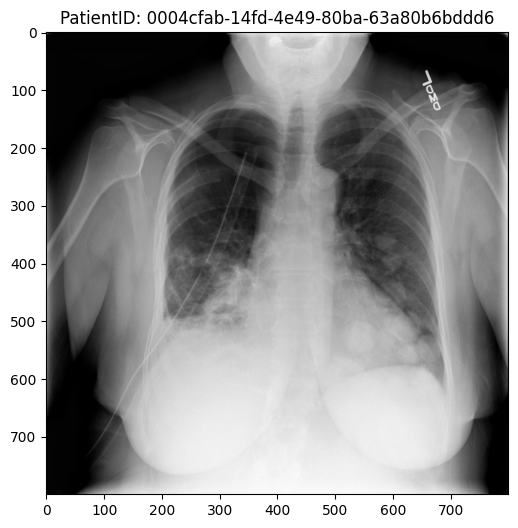

🆔 Patient ID: 000924cf-0f8d-42bd-9158-1af53881a557
📦 BBoxes: []
🏷 Labels: []


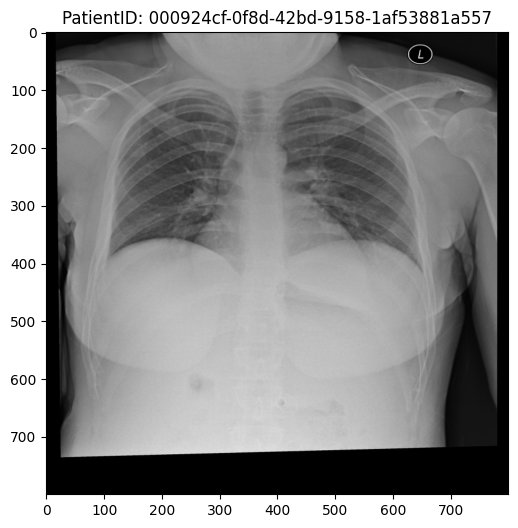

🆔 Patient ID: 000db696-cf54-4385-b10b-6b16fbb3f985
📦 BBoxes: [[247. 248. 133. 373.]
 [516. 293. 114. 314.]]
🏷 Labels: [1 1]


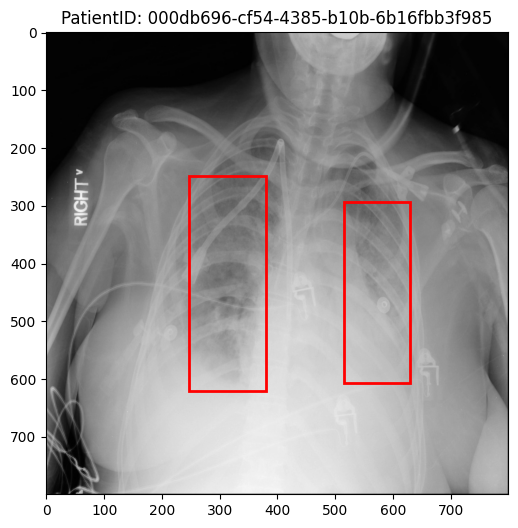

In [39]:
# Cell #3 – Ler e Decodificar Exemplos do TFRecord
import matplotlib.pyplot as plt
import numpy as np

def parse_tfrecord_fn(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'boxes': tf.io.VarLenFeature(tf.float32),
        'labels': tf.io.VarLenFeature(tf.int64),
        'num_boxes': tf.io.FixedLenFeature([], tf.int64),
        'patientId': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    # Decodificar imagem para [0..1]
    img = tf.image.decode_png(parsed_example['image'], channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Decodificar bounding boxes e labels
    num_boxes = parsed_example['num_boxes']
    boxes = tf.sparse.to_dense(parsed_example['boxes'])
    labels = tf.sparse.to_dense(parsed_example['labels'])
    boxes = tf.reshape(boxes, (num_boxes, 4))

    # Extrair o patientId
    patient_id = parsed_example['patientId']

    return img, boxes, labels, patient_id

# Carregar o dataset de treino
train_dataset = tf.data.TFRecordDataset(train_tfrecord_path)
train_dataset = train_dataset.map(parse_tfrecord_fn)

# Visualizar 1 exemplo
for img, boxes, labels, patient_id in train_dataset.take(3):
    # Converter para numpy
    img_np = (img.numpy() * 255).astype(np.uint8)
    boxes_np = boxes.numpy()
    pid_str = patient_id.numpy().decode()

    print(f"🆔 Patient ID: {pid_str}")
    print(f"📦 BBoxes: {boxes_np}")
    print(f"🏷 Labels: {labels.numpy()}")

    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(img_np)
    for (x, y, w, h) in boxes_np:
        rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
    ax.set_title(f"PatientID: {pid_str}")
    plt.show()
    #break  # Apenas mostra 1


In [46]:
# Cell #4 – Comparar IDs do TFRecord vs CSV (para garantir que não haja discrepâncias)
# Coletar todos os IDs do TFRecord de treino
train_ids_in_tfrecord = set()
for _, _, _, pid in train_dataset:
    train_ids_in_tfrecord.add(pid.numpy().decode())

# Coletar todos IDs do dataset original (coluna 'patientId' de balanced_train_data)
train_ids_in_csv = set(train_df["patientId"].astype(str))

print(f"🔍 IDs no TFRecord de treino: {len(train_ids_in_tfrecord)}")
print(f"🔍 IDs no CSV de treino: {len(train_ids_in_csv)}")

missing_in_tfrecord = train_ids_in_csv - train_ids_in_tfrecord
missing_in_csv = train_ids_in_tfrecord - train_ids_in_csv

print(f"⚠️ IDs no CSV mas não no TFRecord: {missing_in_tfrecord}")
print(f"⚠️ IDs no TFRecord mas não no CSV: {missing_in_csv}")


KeyboardInterrupt: 

In [45]:
# 📌 Função para extrair IDs do TFRecord (Treino e Validação)
def extract_tfrecord_ids(dataset):
    ids = set()
    for _, _, _, pid in dataset:
        ids.add(pid.numpy().decode())
    return ids

# 📌 Obter IDs do TFRecord de treino
train_ids_in_tfrecord = extract_tfrecord_ids(train_dataset)
train_ids_in_csv = set(train_df["patientId"].astype(str))

print(f"🔍 IDs no TFRecord de treino: {len(train_ids_in_tfrecord)}")
print(f"🔍 IDs no CSV de treino: {len(train_ids_in_csv)}")
print(f"⚠️ IDs no CSV mas não no TFRecord (Treino): {len(train_ids_in_csv - train_ids_in_tfrecord)}")
print(f"⚠️ IDs no TFRecord mas não no CSV (Treino): {len(train_ids_in_tfrecord - train_ids_in_csv)}")

# 📌 Obter IDs do TFRecord de validação
val_ids_in_tfrecord = extract_tfrecord_ids(val_dataset)
val_ids_in_csv = set(val_df["patientId"].astype(str))

print(f"\n🔍 IDs no TFRecord de validação: {len(val_ids_in_tfrecord)}")
print(f"🔍 IDs no CSV de validação: {len(val_ids_in_csv)}")
print(f"⚠️ IDs no CSV mas não no TFRecord (Validação): {len(val_ids_in_csv - val_ids_in_tfrecord)}")
print(f"⚠️ IDs no TFRecord mas não no CSV (Validação): {len(val_ids_in_tfrecord - val_ids_in_csv)}")


KeyboardInterrupt: 

In [29]:
import tensorflow as tf

# 📌 Configuração do tamanho da imagem
IMAGE_SIZE = (800, 800)  # Mantemos o tamanho original

def load_image(img_path, boxes, labels):
    """
    Lê e processa uma imagem PNG em grayscale, converte para RGB, mantém tamanho original e normaliza.
    
    Args:
        img_path (str): Caminho da imagem.
        boxes (tensor): Tensor contendo as coordenadas das bounding boxes (x, y, width, height).
        labels (tensor): Tensor contendo os rótulos das classes das bounding boxes.
    
    Returns:
        img (tensor): Imagem processada e normalizada.
        target (dict): Dicionário contendo bounding boxes e labels ajustados.
    """
    # 📌 1️⃣ Ler e decodificar a imagem
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)  # Grayscale (Rx são imagens em tons de cinza)

    # 📌 2️⃣ Redimensionar APENAS a imagem (se necessário)
    img = tf.image.resize(img, IMAGE_SIZE)

    # 📌 3️⃣ Converter para RGB (Faster R-CNN e RetinaNet esperam 3 canais)
    img = tf.image.grayscale_to_rgb(img)

    # 📌 4️⃣ Normalizar para [0,1] (padrão para CNNs médicas)
    img = img / 255.0
    
    # Normalizar para o intervalo [-1, 1]
    #img = (img / 127.5) - 1.0  # 🔹 Normaliza para [-1,1]

    # 📌 5️⃣ Garantir que temos bounding boxes (se a imagem for normal, usa caixa vazia)
    if tf.size(boxes) == 0:
        boxes = tf.constant([[0, 0, 0, 0]], dtype=tf.float32)  # 🔹 Bounding box vazia
        labels = tf.constant([0], dtype=tf.int32)  # 🔹 Classe 0 (Normal)

    # 📌 6️⃣ Criar dicionário com bounding boxes e labels (sem escalonamento)
    target = {
        "boxes": boxes,  # Bounding boxes no formato original (800x800)
        "labels": labels  # Labels associadas (0 = Normal, 1 = Pneumonia)
    }

    return img, target

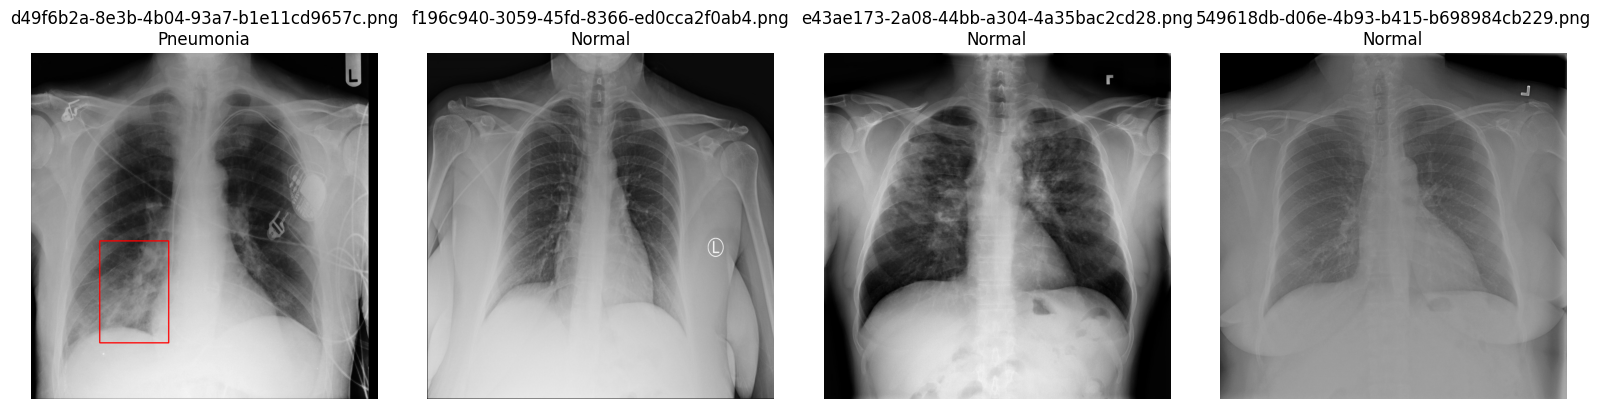

In [30]:
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
import os
import numpy as np  # 🔹 Adicionado para garantir manipulação correta dos arrays

# 📌 Caminho das imagens e bounding boxes
image_folder = "/notebooks/RSNA_Resized_800/"

# 📌 Selecionar um pequeno conjunto de imagens para teste (ex: 4 imagens aleatórias)
num_samples = 4
sample_patients = random.sample(list(train_boxes.keys()), num_samples)

# 📌 Criar figura para exibição
fig, axes = plt.subplots(1, num_samples, figsize=(16, 4))

for i, img_path in enumerate(sample_patients):
    # 📌 Carregar bounding boxes associadas à imagem
    boxes = tf.convert_to_tensor(train_boxes[img_path], dtype=tf.float32)
    labels = tf.ones((len(boxes),), dtype=tf.int32)  # Assumindo 1 para pneumonia

    # 📌 Usar a função load_image para carregar imagem e bounding boxes
    img, target = load_image(img_path, boxes, labels)

    # 📌 Converter a imagem para exibição
    img_np = img.numpy()

    # 🔹 Normalizar imagem para garantir valores entre [0,1]
    img_np = img_np - img_np.min()
    img_np = img_np / img_np.max()

    # 🔹 Converter para uint8 antes de usar OpenCV
    img_np = (img_np * 255).astype(np.uint8)

    # 📌 Verificar se existem bounding boxes válidas
    valid_boxes = [box for box in target["boxes"].numpy() if not all(coord == 0 for coord in box)]
    label = "Pneumonia" if len(valid_boxes) > 0 else "Normal"

    # 📌 Desenhar bounding boxes na imagem carregada
    for box in valid_boxes:  # Apenas desenhar bounding boxes reais
        x, y, w, h = map(int, box)
        cv2.rectangle(img_np, (x, y), (x + w, y + h), (255, 0, 0), 2)  # 🔹 Usa valores corretos de cor

    # 📌 Exibir a imagem com bounding boxes e classe no título
    ax = axes[i]
    ax.imshow(img_np, cmap="gray")
    ax.set_title(f"{os.path.basename(img_path)}\n{label}")
    ax.axis("off")

# 📌 Ajustar layout e mostrar as imagens
plt.tight_layout()
plt.show()

In [31]:
################ JITTER´s ##################

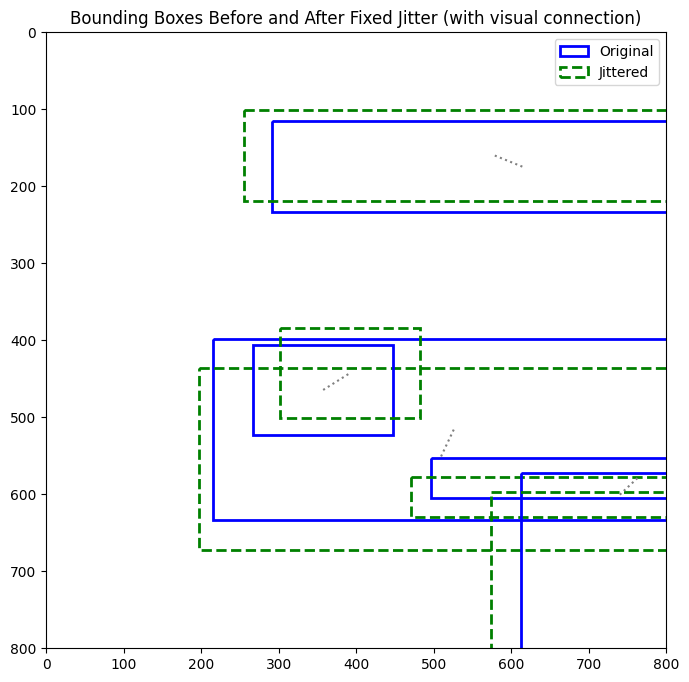

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

# 📌 Definição do tamanho da imagem
IMAGE_SIZE = (800, 800)

def fixed_jitter(bboxes, jitter_ratio=0.05, image_size=IMAGE_SIZE[0]):
    """
    Aplica um deslocamento FIXO com base no tamanho total da imagem.
    O deslocamento máximo em x e y será jitter_ratio * image_size.
    """
    bboxes_out = []
    max_shift = image_size * jitter_ratio  # e.g. 800 * 0.05 = 40 pixels de deslocamento máximo
    
    for box in bboxes.numpy():
        x, y, w, h = box
        
        # ✅ Garante que o deslocamento seja fixo para todas as BBs, independente do tamanho
        # ✅ Se precisar aumentar o jitter, aumente jitter_ratio.
        
        # Gerar deslocamento aleatório em x e y, dentro de [-max_shift, +max_shift]
        shift_x = np.random.uniform(-max_shift, max_shift)
        shift_y = np.random.uniform(-max_shift, max_shift)
        
        # Atualizar coordenadas (mantém w, h)
        new_x = x + shift_x
        new_y = y + shift_y
        
        bboxes_out.append([new_x, new_y, w, h])
    
    return tf.constant(bboxes_out, dtype=tf.float32)

# 📌 Gerar bounding boxes aleatórias para teste
num_boxes = 5
boxes = tf.constant(np.random.randint(50, 750, size=(num_boxes, 4)), dtype=tf.float32)

# 📌 Aplicar jitter fixo
jittered_boxes_fixed = fixed_jitter(boxes)

# 📌 Criar plot para visualização
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlim([0, 800])
ax.set_ylim([0, 800])
ax.invert_yaxis()

for i in range(num_boxes):
    x, y, w, h = boxes[i].numpy()
    x_j, y_j, w_j, h_j = jittered_boxes_fixed[i].numpy()
    
    # Bounding box original (azul sólido)
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none', label="Original" if i == 0 else "")
    ax.add_patch(rect)
    
    # Bounding box jittered (verde tracejado)
    rect_j = patches.Rectangle((x_j, y_j), w_j, h_j, linewidth=2, edgecolor='green', facecolor='none', linestyle='dashed', label="Jittered" if i == 0 else "")
    ax.add_patch(rect_j)
    
    # Linhas ligando os centros das caixas para visualização da variação
    ax.plot([x + w / 2, x_j + w_j / 2], [y + h / 2, y_j + h_j / 2], 'gray', linestyle="dotted")

ax.legend()
ax.set_title("Bounding Boxes Before and After Fixed Jitter (with visual connection)")
plt.show()


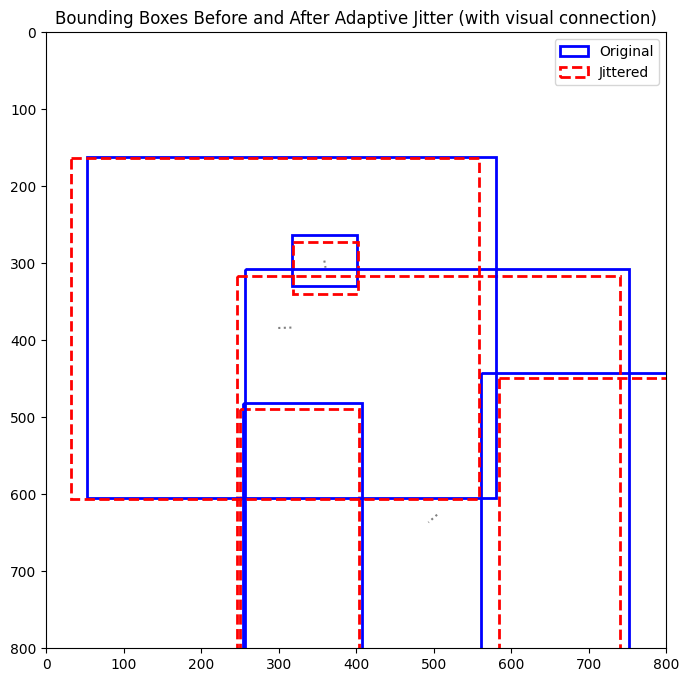

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

def adaptive_jitter(bboxes, jitter_ratio=0.05):
    """
    Jitter Adaptativo: deslocamento é proporcional ao tamanho da BB (w,h).
    """
    bboxes_out = []

    for box in bboxes.numpy():
        x, y, w, h = box
        
        # ✅ Se as BBs pequenas ainda estiverem quase sem jitter, usa os dois ajustes.
        # ✅ Se quiser só um pouco mais de jitter proporcionalmente ao tamanho da BB, aumenta adaptive_factor.
        # ✅ Se quiser um deslocamento mínimo garantido, ajusta max_shift_x e max_shift_y.

        # Ajuste dinâmico para compensar BBs pequenas
        epsilon = 1e-6  # Pequeno valor para evitar divisão por zero
        adaptive_factor = tf.minimum(0.2, jitter_ratio * (800 / (w + h + epsilon)))
        max_shift_x = tf.maximum(w * adaptive_factor, 4.0)  # Garante pelo menos 4px de jitter
        max_shift_y = tf.maximum(h * adaptive_factor, 4.0)  # Garante pelo menos 4px de jitter

        shift_x = np.random.uniform(-max_shift_x, max_shift_x)
        shift_y = np.random.uniform(-max_shift_y, max_shift_y)
        new_x = x + shift_x
        new_y = y + shift_y
        bboxes_out.append([new_x, new_y, w, h])

    bboxes_out = tf.constant(bboxes_out, dtype=tf.float32)
    
    # Clipping se a imagem for 800x800
    bboxes_out = tf.stack([
        tf.clip_by_value(bboxes_out[:,0], 0, 800),
        tf.clip_by_value(bboxes_out[:,1], 0, 800),
        bboxes_out[:,2],
        bboxes_out[:,3],
    ], axis=1)
    
    return bboxes_out

# 📌 Gerar bounding boxes aleatórias para teste
num_boxes = 5
boxes = tf.constant(np.random.randint(50, 750, size=(num_boxes, 4)), dtype=tf.float32)

# 📌 Aplicar jitter
jittered_boxes = adaptive_jitter(boxes)

# 📌 Criar plot para melhor visualização
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlim([0, 800])
ax.set_ylim([0, 800])
ax.invert_yaxis()

for i in range(num_boxes):
    x, y, w, h = boxes[i].numpy()
    x_j, y_j, w_j, h_j = jittered_boxes[i].numpy()
    
    # Bounding box original (azul sólido)
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none', label="Original" if i == 0 else "")
    ax.add_patch(rect)
    
    # Bounding box jittered (vermelho tracejado)
    rect_j = patches.Rectangle((x_j, y_j), w_j, h_j, linewidth=2, edgecolor='red', facecolor='none', linestyle='dashed', label="Jittered" if i == 0 else "")
    ax.add_patch(rect_j)
    
    # Linhas ligando os centros das caixas para visualização da variação
    ax.plot([x + w / 2, x_j + w_j / 2], [y + h / 2, y_j + h_j / 2], 'gray', linestyle="dotted")

ax.legend()
ax.set_title("Bounding Boxes Before and After Adaptive Jitter (with visual connection)")
plt.show()


In [34]:
# Criar a função de IoU

def compute_iou(box1, box2):
    """
    Calcula o IoU (Intersection over Union) entre duas bounding boxes.
    As caixas devem estar no formato [x, y, w, h].
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Coordenadas das caixas
    x1_min, y1_min, x1_max, y1_max = x1, y1, x1 + w1, y1 + h1
    x2_min, y2_min, x2_max, y2_max = x2, y2, x2 + w2, y2 + h2

    # Interseção
    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    inter_w = max(0, inter_xmax - inter_xmin)
    inter_h = max(0, inter_ymax - inter_ymin)
    inter_area = inter_w * inter_h

    # Áreas individuais
    area_box1 = w1 * h1
    area_box2 = w2 * h2

    # União
    union_area = area_box1 + area_box2 - inter_area

    # IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou


In [35]:
# Testar IoU com jitter aplicado
num_boxes = 5  # Número de BBs para teste
boxes = tf.constant(np.random.randint(50, 750, size=(num_boxes, 4)), dtype=tf.float32)

# Aplicar jitter nas BBs
jittered_fixed = fixed_jitter(boxes)
jittered_adaptive = adaptive_jitter(boxes)

# Calcular o IoU entre original e jitterado
ious_fixed = [compute_iou(box.numpy(), jbox.numpy()) for box, jbox in zip(boxes, jittered_fixed)]
ious_adaptive = [compute_iou(box.numpy(), jbox.numpy()) for box, jbox in zip(boxes, jittered_adaptive)]

# Exibir resultados
for i in range(num_boxes):
    print(f"📌 Bounding Box {i+1}:")
    print(f"    IoU (Fixed Jitter)    : {ious_fixed[i]:.4f}")
    print(f"    IoU (Adaptive Jitter) : {ious_adaptive[i]:.4f}")


📌 Bounding Box 1:
    IoU (Fixed Jitter)    : 0.4745
    IoU (Adaptive Jitter) : 0.9451
📌 Bounding Box 2:
    IoU (Fixed Jitter)    : 0.9358
    IoU (Adaptive Jitter) : 0.9513
📌 Bounding Box 3:
    IoU (Fixed Jitter)    : 0.9048
    IoU (Adaptive Jitter) : 0.9064
📌 Bounding Box 4:
    IoU (Fixed Jitter)    : 0.5732
    IoU (Adaptive Jitter) : 0.7967
📌 Bounding Box 5:
    IoU (Fixed Jitter)    : 0.8130
    IoU (Adaptive Jitter) : 0.9071


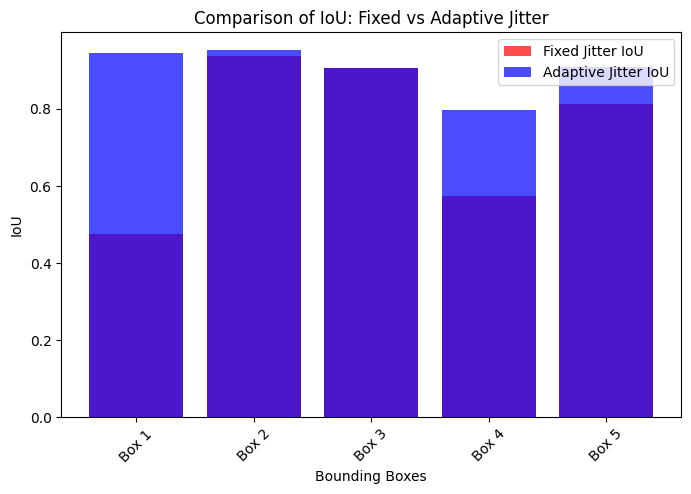

In [36]:
# Criar gráfico comparativo de IoU
fig, ax = plt.subplots(figsize=(8, 5))
x_labels = [f"Box {i+1}" for i in range(num_boxes)]

ax.bar(x_labels, ious_fixed, color='red', alpha=0.7, label="Fixed Jitter IoU")
ax.bar(x_labels, ious_adaptive, color='blue', alpha=0.7, label="Adaptive Jitter IoU")

ax.set_xlabel("Bounding Boxes")
ax.set_ylabel("IoU")
ax.set_title("Comparison of IoU: Fixed vs Adaptive Jitter")
ax.legend()
plt.xticks(rotation=45)
plt.show()


🔍 Processando imagem: /notebooks/RSNA_Resized_800/25d34f4c-7ebe-4fb7-a609-f0d98f5b06c5.png
✅ BBs pequenas encontradas: 1
🚀 Média de deslocamento (Fixed Jitter): [ 1.2844849 10.730438 ]
🚀 Média de deslocamento (Adaptive Jitter): [19.689636   3.6377563]
🔍 Processando imagem: /notebooks/RSNA_Resized_800/6f0797fa-820f-489f-b7d5-75231b307bf7.png
✅ BBs pequenas encontradas: 1
🚀 Média de deslocamento (Fixed Jitter): [4.584732 8.408539]
🚀 Média de deslocamento (Adaptive Jitter): [2.0516052 4.3007812]
🔍 Processando imagem: /notebooks/RSNA_Resized_800/5c50e664-6bcd-4c92-b4d7-aa6a6fb1f46e.png
✅ BBs pequenas encontradas: 1
🚀 Média de deslocamento (Fixed Jitter): [28.517456  8.300537]
🚀 Média de deslocamento (Adaptive Jitter): [7.5787354 2.1333923]
🔍 Processando imagem: /notebooks/RSNA_Resized_800/d59c097e-726a-415f-961b-803b10aa43ed.png
✅ BBs pequenas encontradas: 1
🚀 Média de deslocamento (Fixed Jitter): [24.151962 34.188873]
🚀 Média de deslocamento (Adaptive Jitter): [23.41101    2.1473389]


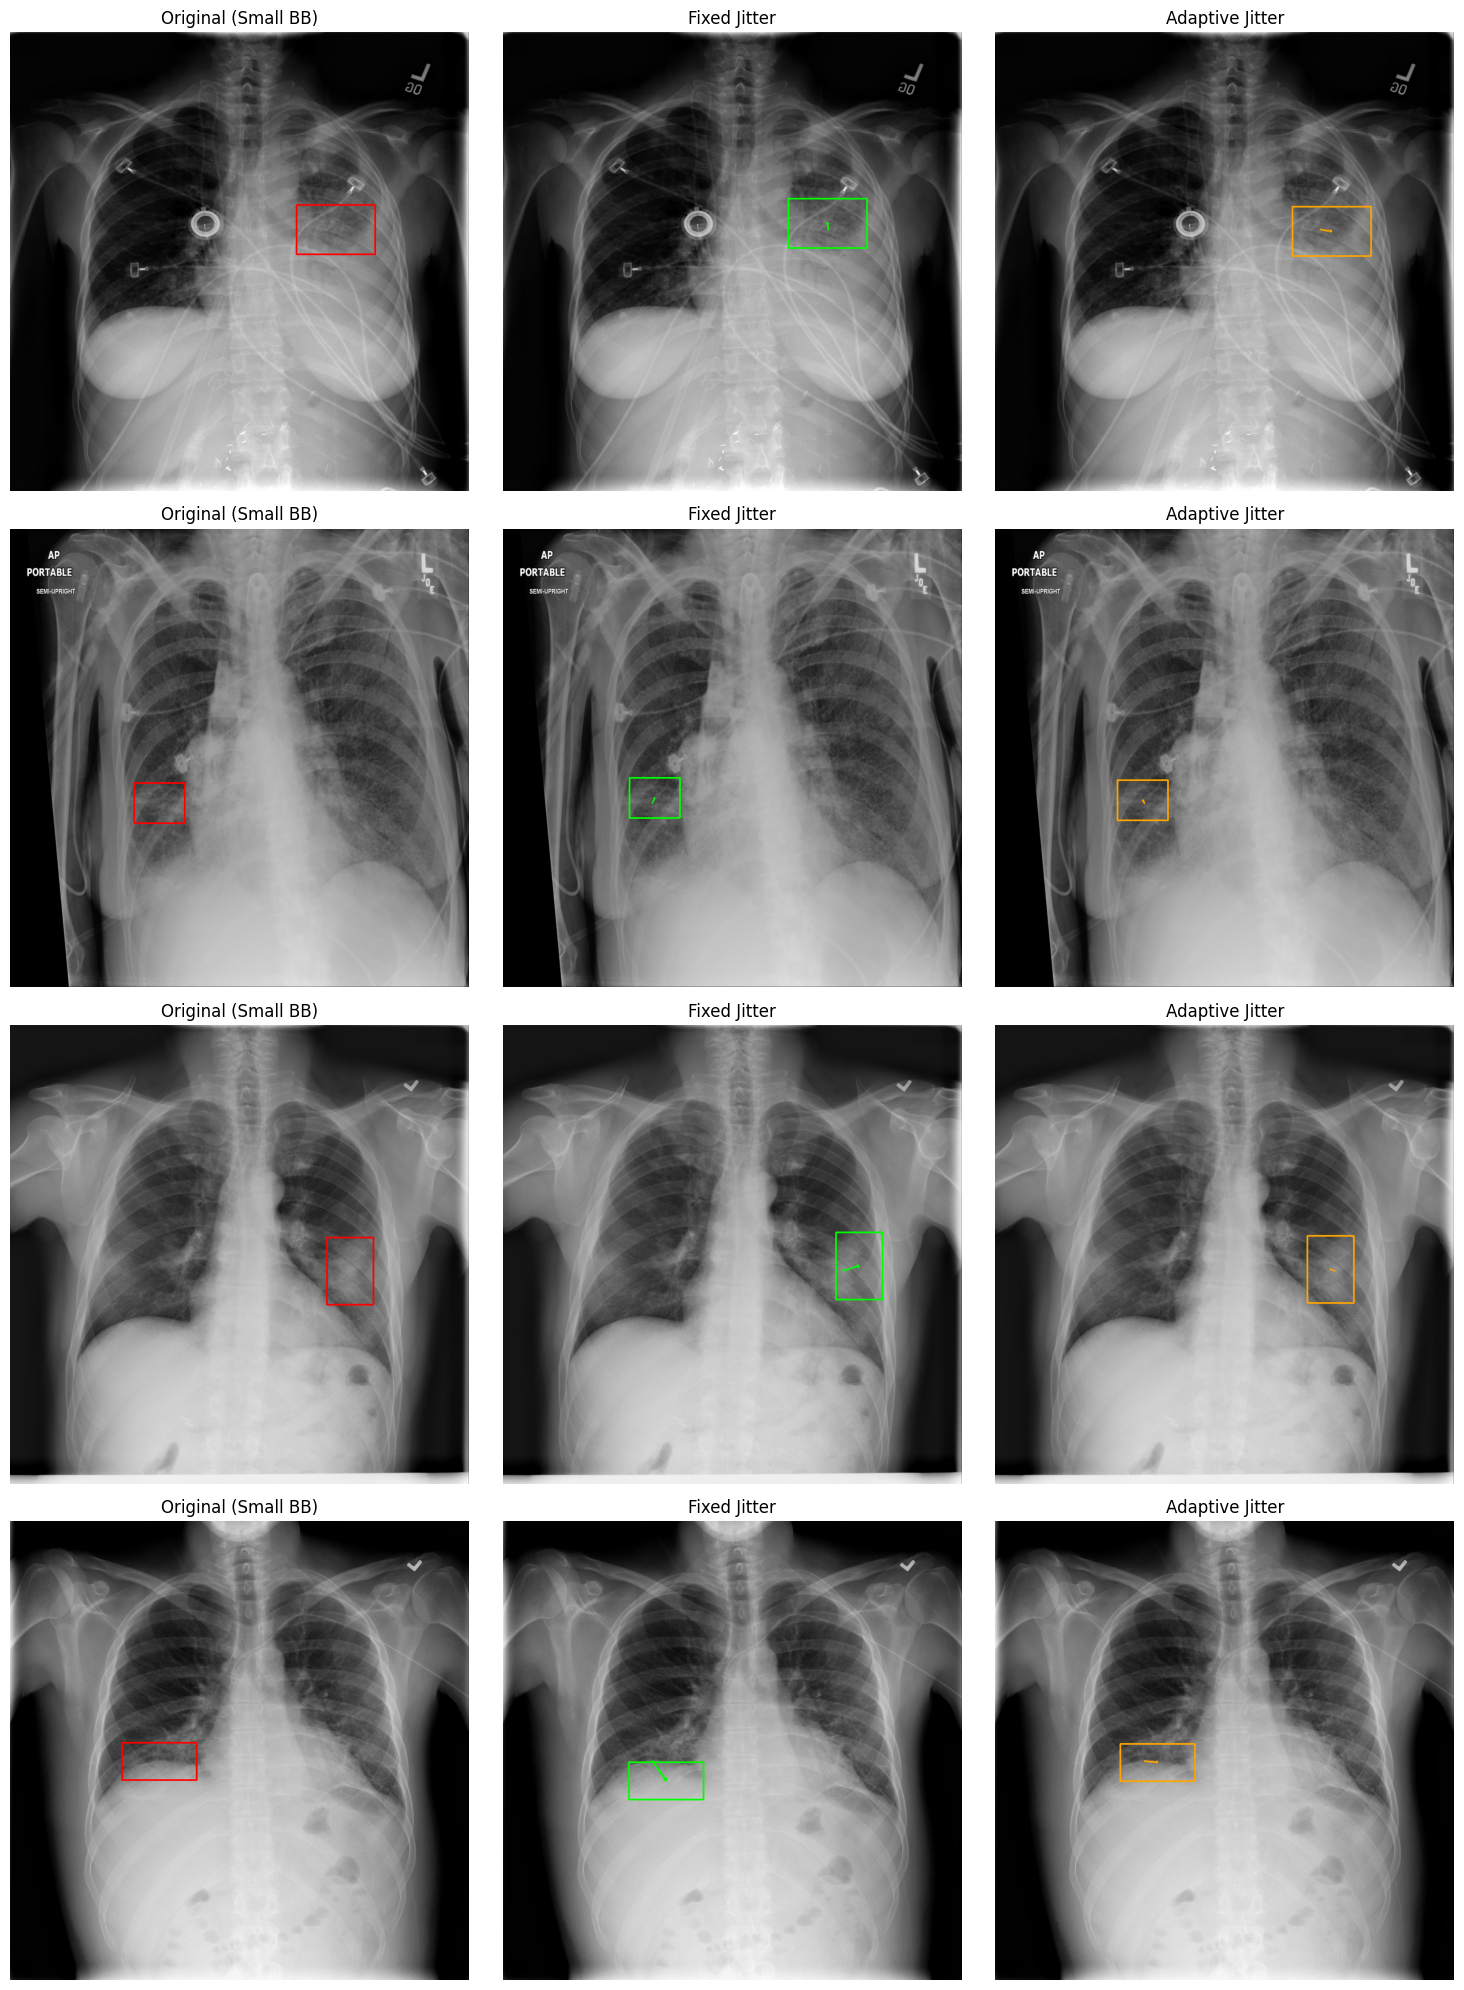

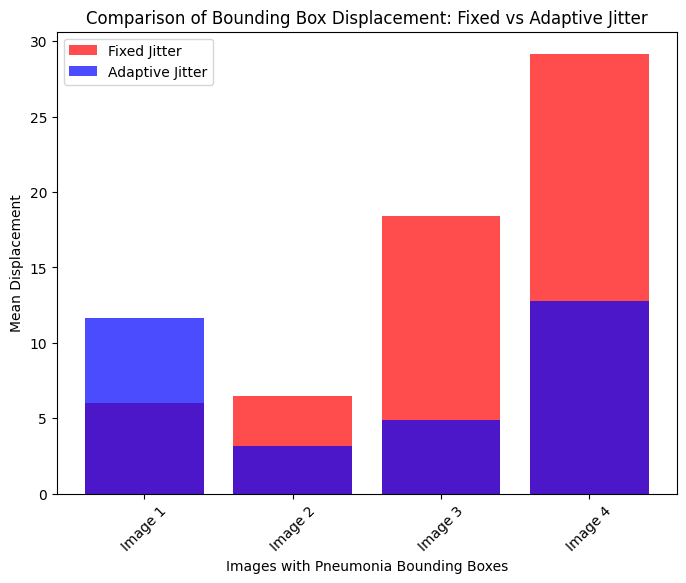

In [37]:
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import tensorflow as tf

# 📌 Inicializar listas globais para armazenar deslocamentos
fixed_displacements = []
adaptive_displacements = []

def get_images_with_small_bboxes(train_boxes, size_threshold=100):
    """
    Filtra imagens que contenham pelo menos uma bounding box pequena.
    """
    filtered_images = []
    for img_path, boxes in train_boxes.items():
        if len(boxes) > 0:  # Apenas imagens com BBs (Pneumonia)
            boxes_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
            small_boxes = tf.boolean_mask(boxes_tensor, tf.logical_or(boxes_tensor[:, 2] < size_threshold, boxes_tensor[:, 3] < size_threshold))
            if tf.size(small_boxes) > 0:  # Se houver pelo menos uma BB pequena
                filtered_images.append(img_path)
    return filtered_images

def compute_avg_displacement(original_boxes, jittered_boxes):
    """
    Calcula o deslocamento médio entre as bounding boxes originais e jittered.
    """
    displacement = tf.reduce_mean(tf.abs(original_boxes[:, :2] - jittered_boxes[:, :2]), axis=0)
    return displacement.numpy()

def visualize_small_bboxes_jitter_pneumonia(image_paths, train_boxes, num_samples=4):
    """
    Visualiza bounding boxes pequenas (para imagens de pneumonia) antes e depois do jitter fixo vs jitter adaptativo.
    """
    global fixed_displacements, adaptive_displacements
    fixed_displacements.clear()
    adaptive_displacements.clear()

    # 📌 Filtrar imagens que tenham BBs pequenas
    pneumonia_images_with_small_bboxes = get_images_with_small_bboxes(train_boxes)

    if len(pneumonia_images_with_small_bboxes) == 0:
        print("⚠️ Nenhuma imagem com BBs pequenas encontrada!")
        return

    # 📌 Selecionar aleatoriamente imagens dentro do critério
    sample_patients = random.sample(pneumonia_images_with_small_bboxes, min(num_samples, len(pneumonia_images_with_small_bboxes)))

    # 📌 Criar subplots dinâmicos
    fig, axes = plt.subplots(len(sample_patients), 3, figsize=(15, 5 * len(sample_patients)))

    for i, img_path in enumerate(sample_patients):
        print(f"🔍 Processando imagem: {img_path}")  # DEBUG

        # 📌 Obter bounding boxes do dicionário
        boxes = tf.convert_to_tensor(train_boxes[img_path], dtype=tf.float32)
        boxes = tf.reshape(boxes, (-1, 4))

        # 📌 Filtrar bounding boxes pequenas
        small_boxes = tf.boolean_mask(boxes, tf.logical_or(boxes[:, 2] < 100, boxes[:, 3] < 100))

        print(f"✅ BBs pequenas encontradas: {tf.shape(small_boxes)[0]}")  # DEBUG

        # 📌 Aplicar jitter fixo e adaptativo
        small_boxes_jittered_fixed = fixed_jitter(small_boxes, jitter_ratio=0.05)
        small_boxes_jittered_adaptive = adaptive_jitter(small_boxes, jitter_ratio=0.05)

        # 🚀 Comparação de deslocamentos médios
        displacement_fixed = compute_avg_displacement(small_boxes, small_boxes_jittered_fixed)
        displacement_adaptive = compute_avg_displacement(small_boxes, small_boxes_jittered_adaptive)

        # 📌 Armazenar deslocamentos médios
        fixed_displacements.append(displacement_fixed)
        adaptive_displacements.append(displacement_adaptive)

        print(f"🚀 Média de deslocamento (Fixed Jitter): {displacement_fixed}")
        print(f"🚀 Média de deslocamento (Adaptive Jitter): {displacement_adaptive}")

        # 📌 Ler a imagem original
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("❌ Erro ao carregar a imagem!")
            continue

        # Redimensionar para 800x800 e converter para RGB (visualização)
        img = cv2.resize(img, (800, 800))
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # 📌 Criar cópias para visualização
        img_fixed = img.copy()
        img_adaptive = img.copy()

        # 📌 Desenhar bounding boxes e setas de deslocamento
        for box, box_jit_fixed, box_jit_adaptive in zip(small_boxes.numpy(), small_boxes_jittered_fixed.numpy(), small_boxes_jittered_adaptive.numpy()):
            x, y, w, h = map(int, box)
            x_f, y_f, w_f, h_f = map(int, box_jit_fixed)
            x_a, y_a, w_a, h_a = map(int, box_jit_adaptive)

            # Bounding box original (azul)
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Bounding box jitter fixo (verde)
            cv2.rectangle(img_fixed, (x_f, y_f), (x_f + w_f, y_f + h_f), (0, 255, 0), 2)

            # Bounding box jitter adaptativo (laranja)
            cv2.rectangle(img_adaptive, (x_a, y_a), (x_a + w_a, y_a + h_a), (255, 165, 0), 2)

            # 🔹 Setas para destacar deslocamentos
            cv2.arrowedLine(img_fixed, (x + w // 2, y + h // 2), (x_f + w_f // 2, y_f + h_f // 2), (0, 255, 0), 2)
            cv2.arrowedLine(img_adaptive, (x + w // 2, y + h // 2), (x_a + w_a // 2, y_a + h_a // 2), (255, 165, 0), 2)

        # 📌 Ajustar os subplots
        if len(sample_patients) == 1:
            ax_orig, ax_fixed, ax_adap = axes
        else:
            ax_orig, ax_fixed, ax_adap = axes[i]

        ax_orig.imshow(img)
        ax_orig.set_title("Original (Small BB)")
        ax_orig.axis("off")

        ax_fixed.imshow(img_fixed)
        ax_fixed.set_title("Fixed Jitter")
        ax_fixed.axis("off")

        ax_adap.imshow(img_adaptive)
        ax_adap.set_title("Adaptive Jitter")
        ax_adap.axis("off")

    plt.tight_layout()
    plt.show()

# 📌 Executar a visualização e armazenar deslocamentos
visualize_small_bboxes_jitter_pneumonia(list(train_boxes.keys()), train_boxes, num_samples=4)

# 📌 Converter listas para arrays NumPy
fixed_displacements = np.array(fixed_displacements)
adaptive_displacements = np.array(adaptive_displacements)

# 📌 Calcular média do deslocamento por imagem
fixed_mean = np.mean(fixed_displacements, axis=1)
adaptive_mean = np.mean(adaptive_displacements, axis=1)

# 📌 Criar gráfico comparativo automaticamente
fig, ax = plt.subplots(figsize=(8, 6))
image_labels = [f"Image {i+1}" for i in range(len(fixed_mean))]

ax.bar(image_labels, fixed_mean, color='red', alpha=0.7, label="Fixed Jitter")
ax.bar(image_labels, adaptive_mean, color='blue', alpha=0.7, label="Adaptive Jitter")

ax.set_xlabel("Images with Pneumonia Bounding Boxes")
ax.set_ylabel("Mean Displacement")
ax.set_title("Comparison of Bounding Box Displacement: Fixed vs Adaptive Jitter")
ax.legend()
plt.xticks(rotation=45)
plt.show()

Imagem: /notebooks/RSNA_Resized_800/6bf02e28-807b-4020-a18a-3d34fed0d3aa.png
Deslocamentos Fixos: [[15.394836 25.143402]]
Deslocamentos Adaptativos: [[ 5.157898 25.467957]]

Imagem: /notebooks/RSNA_Resized_800/69b6a3c9-16d2-4936-bf61-4ca8a10722c6.png
Deslocamentos Fixos: [[12.500198 23.27118 ]]
Deslocamentos Adaptativos: [[ 2.238388 10.583313]]

Imagem: /notebooks/RSNA_Resized_800/0d4cb628-fdfd-4a4f-838d-9054ed99cc9e.png
Deslocamentos Fixos: [[ 4.1341095 18.565674 ]]
Deslocamentos Adaptativos: [[ 7.950165 11.749634]]

Imagem: /notebooks/RSNA_Resized_800/c3e28b77-4477-4e36-89a7-ec0713349d4b.png
Deslocamentos Fixos: [[14.998474 21.50711 ]]
Deslocamentos Adaptativos: [[19.759491  9.126221]]



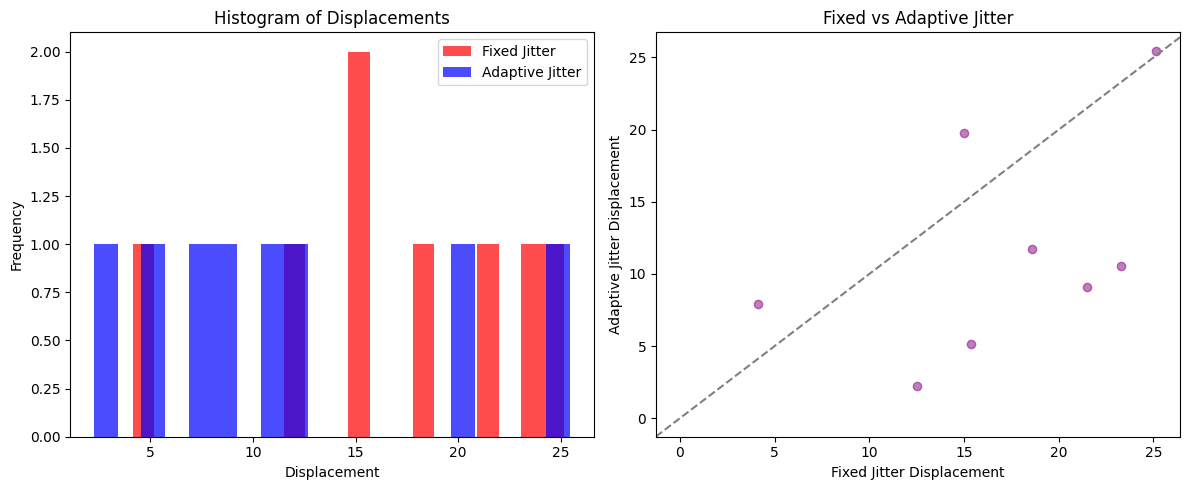

In [38]:
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import tensorflow as tf

def compute_avg_displacement(original_boxes, jittered_boxes):
    displacement = tf.abs(original_boxes[:, :2] - jittered_boxes[:, :2])
    return displacement.numpy()

def visualize_jitter_displacements(fixed_displacements, adaptive_displacements):
    """
    Gera histogramas e scatter plots para analisar os deslocamentos individuais.
    """

    if not fixed_displacements or not adaptive_displacements:
        print("⚠️ Nenhum deslocamento disponível para visualização!")
        return

    fixed_displacements = np.vstack(fixed_displacements)
    adaptive_displacements = np.vstack(adaptive_displacements)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histograma
    axes[0].hist(fixed_displacements.flatten(), bins=20, alpha=0.7, color='red', label="Fixed Jitter")
    axes[0].hist(adaptive_displacements.flatten(), bins=20, alpha=0.7, color='blue', label="Adaptive Jitter")
    axes[0].set_title("Histogram of Displacements")
    axes[0].set_xlabel("Displacement")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()
    
    # Scatter plot
    axes[1].scatter(fixed_displacements.flatten(), adaptive_displacements.flatten(), alpha=0.5, c='purple')
    axes[1].set_title("Fixed vs Adaptive Jitter")
    axes[1].set_xlabel("Fixed Jitter Displacement")
    axes[1].set_ylabel("Adaptive Jitter Displacement")
    axes[1].axline((0, 0), slope=1, linestyle="--", color="gray")
    
    plt.tight_layout()
    plt.show()

def visualize_small_bboxes_jitter_pneumonia(train_boxes, num_samples=4):
    fixed_displacements = []
    adaptive_displacements = []
    
    pneumonia_images_with_small_bboxes = get_images_with_small_bboxes(train_boxes)
    if len(pneumonia_images_with_small_bboxes) == 0:
        print("⚠️ Nenhuma imagem com BBs pequenas encontrada!")
        return
    
    sample_patients = random.sample(pneumonia_images_with_small_bboxes, min(num_samples, len(pneumonia_images_with_small_bboxes)))
    
    for img_path in sample_patients:
        boxes = tf.convert_to_tensor(train_boxes[img_path], dtype=tf.float32)
        boxes = tf.reshape(boxes, (-1, 4))
        small_boxes = tf.boolean_mask(boxes, tf.logical_or(boxes[:, 2] < 100, boxes[:, 3] < 100))
        
        small_boxes_jittered_fixed = fixed_jitter(small_boxes, jitter_ratio=0.05)
        small_boxes_jittered_adaptive = adaptive_jitter(small_boxes, jitter_ratio=0.05)
        
        displacement_fixed = compute_avg_displacement(small_boxes, small_boxes_jittered_fixed)
        displacement_adaptive = compute_avg_displacement(small_boxes, small_boxes_jittered_adaptive)
        
        if displacement_fixed.shape[0] > 0:
            fixed_displacements.append(displacement_fixed)
        if displacement_adaptive.shape[0] > 0:
            adaptive_displacements.append(displacement_adaptive)
        
        print(f"Imagem: {img_path}")
        print(f"Deslocamentos Fixos: {displacement_fixed}")
        print(f"Deslocamentos Adaptativos: {displacement_adaptive}\n")
    
    visualize_jitter_displacements(fixed_displacements, adaptive_displacements)

# Executar análise
visualize_small_bboxes_jitter_pneumonia(train_boxes, num_samples=4)


In [39]:
import tensorflow as tf
import numpy as np

# 📌 Define o tamanho da imagem
#IMAGE_SIZE = (800, 800)  

def tf_rotate_alternative(image, boxes, angle_deg):
    """
    Rotaciona a imagem e ajusta bounding boxes mantendo-as dentro dos limites.
    """
    angle_rad = angle_deg * (np.pi / 180.0)
    cos_angle = tf.math.cos(angle_rad)
    sin_angle = tf.math.sin(angle_rad)
    img_center = tf.constant([400, 400], dtype=tf.float32)

    # Matriz de transformação para a imagem
    transforms = tf.stack([
        cos_angle, -sin_angle, (1 - cos_angle) * img_center[0] + sin_angle * img_center[1],
        sin_angle,  cos_angle, (1 - cos_angle) * img_center[1] - sin_angle * img_center[0],
        0.0,        0.0,       1.0
    ])
    transforms = tf.reshape(transforms[:8], [1, 8])

    # Rotacionar imagem
    rotated_image = tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(image, 0),
        transforms=transforms,
        output_shape=IMAGE_SIZE,
        interpolation="BILINEAR",
        fill_mode="NEAREST",
        fill_value=0.5
    )
    rotated_image = tf.squeeze(rotated_image, axis=0)

    # Ajustar bounding boxes
    # Converter (x, y, w, h) para (x1, y1, x2, y2)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]
    y2 = y1 + boxes[:, 3]

    corners = tf.stack([
        tf.stack([x1, y1], axis=1),
        tf.stack([x2, y1], axis=1),
        tf.stack([x2, y2], axis=1),
        tf.stack([x1, y2], axis=1),
    ], axis=1)  # (num_boxes, 4, 2)

    # Centralizar
    centered_corners = corners - img_center

    # Aplicar rotação
    rotation_mat = tf.convert_to_tensor([[cos_angle, -sin_angle],
                                         [sin_angle,  cos_angle]], dtype=tf.float32)
    rotated_corners = tf.einsum('ij,bkj->bki', rotation_mat, centered_corners)

    # Descentralizar de volta
    rotated_corners = rotated_corners + img_center

    # Novas bounding boxes
    new_x1 = tf.reduce_min(rotated_corners[:, :, 0], axis=1)
    new_y1 = tf.reduce_min(rotated_corners[:, :, 1], axis=1)
    new_x2 = tf.reduce_max(rotated_corners[:, :, 0], axis=1)
    new_y2 = tf.reduce_max(rotated_corners[:, :, 1], axis=1)

    new_boxes = tf.stack([new_x1, new_y1, new_x2 - new_x1, new_y2 - new_y1], axis=1)
    new_boxes = tf.clip_by_value(new_boxes, 0.0, 800.0)

    return rotated_image, new_boxes

In [40]:
# 📌 Define o tamanho da imagem
#IMAGE_SIZE = (800, 800)

def apply_zoom(image, boxes, zoom_factor):
    """
    Aplica zoom e ajusta bounding boxes.
    """
    height, width = IMAGE_SIZE
    new_height = tf.cast(zoom_factor * tf.cast(height, tf.float32), tf.int32)
    new_width  = tf.cast(zoom_factor * tf.cast(width, tf.float32), tf.int32)

    # Resize e depois crop/pad para manter 800x800
    image = tf.image.resize(image, [new_height, new_width], method="nearest")
    image = tf.image.resize_with_crop_or_pad(image, height, width)

    # Ajustar bounding boxes
    boxes = boxes * zoom_factor
    boxes = tf.clip_by_value(boxes, 0.0, 800.0)

    return image, boxes


In [41]:
import tensorflow as tf

def random_pad(image, boxes, max_pad=15, target_size=(800, 800), fill_value=0.5):
    """
    Aplica padding aleatório à imagem e ajusta as bounding boxes para manter a coerência.

    Args:
        image (tensor): Imagem original.
        boxes (tensor): Bounding boxes no formato [x, y, width, height].
        max_pad (int): Valor máximo de padding. Agora garantimos que seja sempre maior que 0.
        target_size (tuple): Tamanho final da imagem após o redimensionamento.
        fill_value (float): Valor de preenchimento do padding.

    Returns:
        image (tensor): Imagem com padding aplicado.
        boxes (tensor): Bounding boxes ajustadas ao novo tamanho.
    """

    # 📌 Garantir que max_pad nunca seja 0
    max_pad = tf.maximum(max_pad, 1)

    # 🔹 Definir um padding aleatório entre 0 e max_pad
    pad_x = tf.random.uniform([], minval=0, maxval=max_pad, dtype=tf.int32)
    pad_y = tf.random.uniform([], minval=0, maxval=max_pad, dtype=tf.int32)

    # 🔹 Aplicar padding na altura e largura
    image = tf.pad(image, [[pad_y, pad_y], [pad_x, pad_x], [0, 0]], mode="CONSTANT", constant_values=fill_value)

    # 🔹 Ajustar bounding boxes para o novo tamanho
    new_x = boxes[:, 0] + tf.cast(pad_x, tf.float32)
    new_y = boxes[:, 1] + tf.cast(pad_y, tf.float32)
    new_w = boxes[:, 2]
    new_h = boxes[:, 3]

    new_boxes = tf.stack([new_x, new_y, new_w, new_h], axis=-1)

    # 🔹 Redimensionar para manter o tamanho original
    image = tf.image.resize(image, target_size, method="bilinear") 

    return image, new_boxes


In [42]:
import tensorflow as tf

def adjust_sharpness(image, factor=1.0, apply_sharpness=False):
    """
    Ajusta a nitidez da imagem opcionalmente.

    Parâmetros:
    - image: Tensor da imagem (H, W, 3).
    - factor: Intensidade do ajuste (1.0 = original, >1.0 = mais nítido, <1.0 = mais suave).
    - apply_sharpness: Se True, aplica a alteração de nitidez. Se False, retorna a imagem original.

    Retorna:
    - Imagem ajustada (ou a imagem original se apply_sharpness=False).
    """

    if not apply_sharpness:
        return image  # Retorna a imagem original sem alterações

    # Kernel para nitidez
    kernel = tf.constant([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1]
    ], dtype=tf.float32)

    # Adaptar o kernel para 3 canais (R, G, B)
    kernel = tf.expand_dims(kernel, axis=-1)  # Adicionar dimensão para input channels
    kernel = tf.tile(kernel, [1, 1, 3])      # Replicar para 3 canais
    kernel = tf.expand_dims(kernel, axis=-1) # Adicionar dimensão para output channels

    # Aplicar convolução
    sharp_image = tf.nn.depthwise_conv2d(
        input=tf.expand_dims(image, axis=0),  # Adicionar dimensão do batch
        filter=kernel,
        strides=[1, 1, 1, 1],
        padding="SAME"
    )
    sharp_image = tf.squeeze(sharp_image, axis=0)  # Remover dimensão do batch

    # Misturar a imagem original com a imagem nítida
    image = factor * sharp_image + (1.0 - factor) * image
    image = tf.clip_by_value(image, 0.0, 1.0)  # Garantir valores no intervalo [0, 1]

    return image


#Quando quisermos ativar o ajuste de nitidez, basta chamar assim:

# image = adjust_sharpness(image, factor=1.2, apply_sharpness=True)
# ou
# image = adjust_sharpness(image, apply_sharpness=False)

In [43]:
import tensorflow as tf

def random_augment(image, target):
    """
    Aplica Data Augmentation para TODAS as imagens (Normais e Pneumonia).
    Ajusta bounding boxes corretamente após cada transformação.
    """

    image_aug = image
    boxes = target["boxes"]

    # 📌 **Garantir que as bounding boxes nunca estejam vazias**
    if tf.size(boxes) == 0:
        boxes = tf.constant([[0, 0, 1, 1]], dtype=tf.float32)  # 🔹 Bounding box mínima para evitar erro
    
    # 📌 **Garantir que `boxes` tenha shape correto**
    boxes = tf.reshape(boxes, (-1, 4))

    # 📌 **Rotação Aleatória (Ajustar BBs)**
    angle_deg = tf.random.uniform([], minval=-8, maxval=8, dtype=tf.float32)
    image_aug, boxes = tf_rotate_alternative(image_aug, boxes, angle_deg)

    # 📌 **Jitter Aleatório Adaptativo**
    boxes = adaptive_jitter(boxes, jitter_ratio=0.05)  # 🔹 Pequenos deslocamentos proporcionais ao tamanho

    # 📌 **Ajuste de Brilho e Contraste**
    image_aug = tf.image.random_brightness(image_aug, max_delta=0.1)
    image_aug = tf.image.random_contrast(image_aug, lower=0.9, upper=1.1)

    # 📌 **Zoom Aleatório (Ajustar BBs)**
    zoom_scale = tf.random.uniform([], minval=0.98, maxval=1.02)
    image_aug, boxes = apply_zoom(image_aug, boxes, zoom_scale)

    # 📌 **Padding Aleatório (Ajustar BBs)**
    pad = tf.random.uniform([], minval=0, maxval=5, dtype=tf.int32)
    image_aug, boxes = random_pad(image_aug, boxes, pad)

    # 📌 **Ajuste de Nitidez (50% das vezes)**
    apply_sharpness = tf.random.uniform([], 0, 1) > 0.5  
    image_aug = adjust_sharpness(image_aug, factor=1.2, apply_sharpness=apply_sharpness)

    # 📌 **Evitar valores fora do intervalo [0,1]**
    image_aug = tf.clip_by_value(image_aug, 0.0, 1.0)

    # 📌 **Garantir que bounding boxes têm tamanhos válidos**
    x, y, w, h = tf.unstack(boxes, axis=1)
    w = tf.maximum(1.0, w)  # 🔹 Garante largura mínima
    h = tf.maximum(1.0, h)  # 🔹 Garante altura mínima
    boxes = tf.stack([x, y, w, h], axis=1)

    return image_aug, {"boxes": boxes, "labels": target["labels"]}


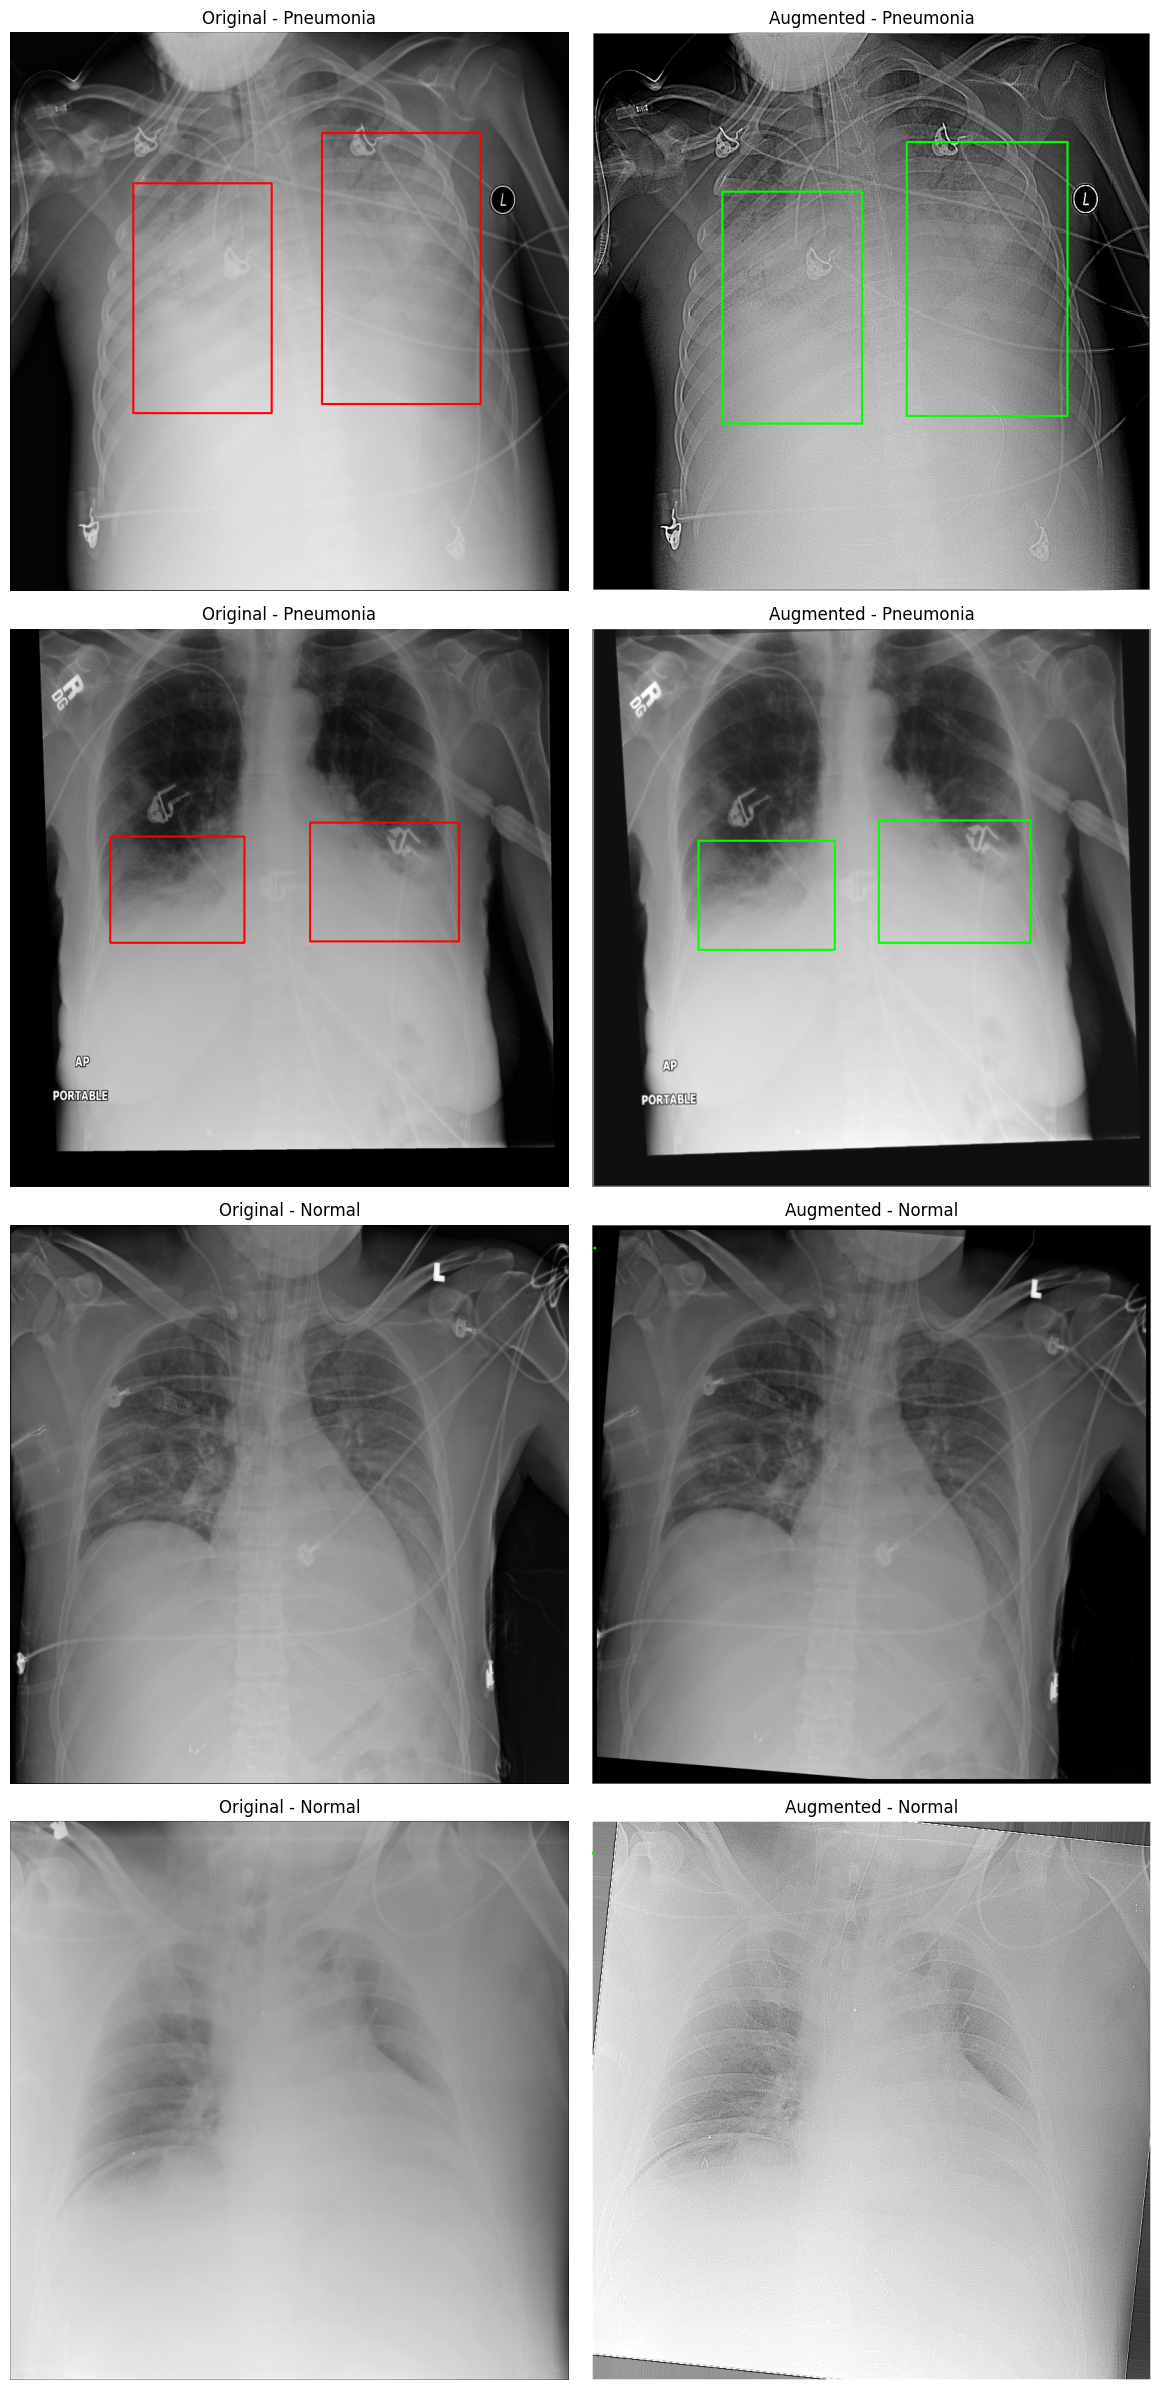

In [44]:
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import tensorflow as tf

def visualize_augmentation(image_paths, train_boxes, num_samples=4):
    """
    Visualiza a aplicação de data augmentation comparando imagem original vs aumentada,
    garantindo que 2 imagens sejam "Normal" e 2 sejam "Pneumonia".

    Args:
        image_paths (list): Lista de caminhos das imagens.
        train_boxes (dict): Dicionário com bounding boxes associadas a cada imagem.
        num_samples (int): Número total de imagens a exibir (padrão: 4, sendo 2 normais e 2 com pneumonia).
    """

    # 📌 Separar imagens de "Normal" e "Pneumonia"
    normal_images = [p for p in image_paths if len(train_boxes.get(p, [])) == 0]
    pneumonia_images = [p for p in image_paths if len(train_boxes.get(p, [])) > 0]

    # 📌 Garantir que temos imagens suficientes
    if len(normal_images) < 2 or len(pneumonia_images) < 2:
        raise ValueError("Não há imagens suficientes de cada classe para visualização!")

    # 📌 Selecionar 2 imagens normais e 2 imagens com pneumonia
    selected_normals = random.sample(normal_images, 2)
    selected_pneumonias = random.sample(pneumonia_images, 2)

    # 📌 Juntar todas as imagens selecionadas
    sample_patients = selected_pneumonias + selected_normals
    labels_list = ["Pneumonia", "Pneumonia", "Normal", "Normal"]  # Para títulos

    # 📌 Criar figura para exibição (2 colunas: Original e Aumentada)
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 6 * num_samples))

    for i, (img_path, class_label) in enumerate(zip(sample_patients, labels_list)):
        # 📌 Carregar bounding boxes associadas à imagem
        boxes = tf.convert_to_tensor(train_boxes.get(img_path, []), dtype=tf.float32)
        labels = tf.ones((len(boxes),), dtype=tf.int32) if len(boxes) > 0 else tf.zeros((1,), dtype=tf.int32)

        # 📌 Carregar imagem original
        img, target = load_image(img_path, boxes, labels)

        # 📌 Aplicar data augmentation
        img_aug, target_aug = random_augment(img, target)

        # 📌 **Converter para uint8 corretamente**
        img_np = (img.numpy() * 255).astype(np.uint8)
        img_aug_np = (img_aug.numpy() * 255).astype(np.uint8)

        # 📌 Desenhar bounding boxes nas imagens (original e aumentada)
        for box in target["boxes"].numpy():
            x, y, w, h = map(int, box)
            cv2.rectangle(img_np, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Azul para Original

        for box in target_aug["boxes"].numpy():
            x, y, w, h = map(int, box)
            cv2.rectangle(img_aug_np, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Verde para Aumentada

        # 📌 Exibir imagens
        axes[i, 0].imshow(img_np, cmap="gray")
        axes[i, 0].set_title(f"Original - {class_label}", fontsize=12)
        axes[i, 0].axis("off")

        axes[i, 1].imshow(img_aug_np, cmap="gray")
        axes[i, 1].set_title(f"Augmented - {class_label}", fontsize=12)
        axes[i, 1].axis("off")

    # 📌 Ajustar layout
    plt.tight_layout()
    plt.show()

# 📌 Testar a função
visualize_augmentation(list(train_boxes.keys()), train_boxes, num_samples=4)


In [45]:
print(f"Tamanho de train_image_paths: {len(train_image_paths)}")
print(f"Tamanho de train_boxes: {len(train_boxes)}")
print(f"Tamanho de train_labels: {len(train_labels)}")
print(f"Tamanho de val_image_paths: {len(val_image_paths)}")
print(f"Tamanho de val_boxes: {len(val_boxes)}")
print(f"Tamanho de val_labels: {len(val_labels)}")


Tamanho de train_image_paths: 21347
Tamanho de train_boxes: 21347
Tamanho de train_labels: 21347
Tamanho de val_image_paths: 5337
Tamanho de val_boxes: 5337
Tamanho de val_labels: 5337


In [46]:
BATCH_SIZE = 8  # Ajuste conforme a memória disponível

# Criar função para construir o dataset
def create_tf_dataset(image_paths, boxes, labels, batch_size=BATCH_SIZE, augment=False, shuffle=False):
    """
    Cria um dataset tf.data para detecção de objetos, com:
    - Leitura das imagens
    - Augmentation opcional
    - Normalização correta para Faster R-CNN e RetinaNet
    """
    ds = tf.data.Dataset.from_tensor_slices((image_paths, boxes, labels))
    ds = ds.map(lambda img, box, lbl: load_image(img, box, lbl), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=3000, reshuffle_each_iteration=True)

    if augment:
        ds = ds.map(random_augment, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Criar datasets corrigidos para treino e validação
train_dataset = create_tf_dataset(
    train_image_paths, train_boxes_list, train_labels, batch_size=BATCH_SIZE, augment=True, shuffle=True
)

val_dataset = create_tf_dataset(
    val_image_paths, val_boxes_list, val_labels, batch_size=BATCH_SIZE, augment=False, shuffle=False
)

# 📌 Testar um batch do dataset
sample_batch = next(iter(train_dataset.take(1)))
sample_images, sample_targets = sample_batch

print(f"Tamanho do batch carregado: {sample_images.shape}")
print(f"Exemplo de bounding boxes no batch: {sample_targets['boxes']}")
print(f"Exemplo de labels no batch: {sample_targets['labels']}")


InvalidArgumentError: {{function_node __wrapped__Pack_N_21347_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [1] != values[4].shape = [2] [Op:Pack] name: component_2